In [1]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.gridspec import GridSpec
import numpy as np
import pickle
import torch
import os
import sys
sys.path.insert(0,'../code/data_utils/SampleClass/')
from Coordinates import Coordinates
sys.path.insert(1,'../code/data_utils/')
from HiCDataset import HiCDataset
sys.path.insert(2,'./support/')
# Analysis code from https://github.com/BogdanBintu/ChromatinImaging/blob/master/CommonTools/PostAnalysisTools.py
from PostAnalysisTools import StandardBoundaryAnalysis 
plt.style.use('/home/gridsan/gschuette/universal/matplotlib/plot_style_2.txt')

#### Paths to various data files, names associated with each set of conformations

Where to save the figure(s)

In [2]:
save_folder = './domains/'

Case 1: Look at two regions within GM12878

In [3]:
no_features_fp = '../data/samples/origami_64_no_embed_reduction/eval_mode/sample_1243_5.0_8.0_120_X.pt'
features_fp = '../data/samples/origami_64_no_embed_reduction/eval_mode/sample_730_5.0_8.0_120_1.pt'
no_features_tag = 'Chromosome X: 25.08-26.36 Mb'
features_tag = 'Chromosome 1: 17.12-18.4 Mb'

no_features_chrom = 'X'
no_features_start = 25_080_000
no_features_stop = 26_360_000

features_chrom = '1'
features_start = 17_120_000
features_stop = 18_400_000

Case 2: Look at the same region in different cell types

In [4]:
gm_conformation_fp1 = '../data/samples/origami_64_no_embed_reduction/eval_mode/sample_668_5.0_8.0_120_21.pt'
imr_conformation_fp1 = '../data/samples/origami_64_no_embed_reduction/cross_validation/IMR/sample_668_5.0_8.0_120_21.pt'
gm_tag = 'GM12878'
imr_tag = 'IMR-90'

gm_conformation_fp2 = '../data/samples/origami_64_no_embed_reduction/eval_mode/'+\
'sample_668_1.0_0.0_120_21.pt'
imr_conformation_fp2 = '../data/samples/origami_64_no_embed_reduction/cross_validation/IMR/'+\
'sample_668_1.0_0.0_120_21.pt'

gm_imr_chrom = '21'
gm_imr_start = 28_500_000
gm_imr_stop = 29_780_000

ratio = 0.5

Add location information to the IMR vs GM regions to differentiate them in the later dictionaries

In [5]:
gm_tag1 = gm_tag + '\\' + f'{gm_imr_chrom}_{gm_imr_start}_{gm_imr_stop}'
imr_tag1 = imr_tag + '\\' + f'{gm_imr_chrom}_{gm_imr_start}_{gm_imr_stop}'
gm_tag2 = gm_tag + '\\' + f'{gm_imr_chrom}_{gm_imr_start}_{gm_imr_stop}_0'
imr_tag2 = imr_tag + '\\' + f'{gm_imr_chrom}_{gm_imr_start}_{gm_imr_stop}_0'
combined_gm_tag = gm_tag + '\\' + f'{gm_imr_chrom}_{gm_imr_start}_{gm_imr_stop}_{ratio}'
combined_imr_tag = imr_tag + '\\' + f'{gm_imr_chrom}_{gm_imr_start}_{gm_imr_stop}_{ratio}'

Where to save the processed boundary data

In [6]:
boundary_file='./support/boundary_file.pkl'
#boundary_file='./support/test.pkl'

Experimental Hi-C filepaths

In [7]:
gm_mcool_fp = '../data/outside/GM12878_hg19.mcool'
imr_mcool_fp = '../data/outside/IMR90_hg19.mcool'

#### Load the conformation, Hi-C data & place in dictionaries for convenience

Conformations

In [8]:
coord_dict = {
    imr_tag1:Coordinates(imr_conformation_fp1),
    gm_tag1:Coordinates(gm_conformation_fp1),
    imr_tag2:Coordinates(imr_conformation_fp2),
    gm_tag2:Coordinates(gm_conformation_fp2)
}

# Create combined sets for imr, gm 

for coords1,coords2,combined_tag in [
    (coord_dict[gm_tag1],coord_dict[gm_tag2],combined_gm_tag),
    (coord_dict[imr_tag1],coord_dict[imr_tag2],combined_imr_tag)
]:

    n = min(len(coords1),len(coords2))
    n2 = int(n * ratio) # Number to take from the w=1 case
    n1 = n - n2
    # Could shuffle conformations at this step, but don't for reproducability's sake
    coord_dict[combined_tag] = coords1[:n1].append(coords2[:n2])

for tag in [gm_tag2,imr_tag2]:
    coord_dict.pop(tag)

# Convert to nm
for _,coords in coord_dict.items():
    coords._values*= 100

In [9]:
gm_hic = HiCDataset(gm_mcool_fp)
imr_hic = HiCDataset(imr_mcool_fp)

hic_maps = {
    combined_imr_tag:imr_hic.fetch(gm_imr_chrom,gm_imr_start,gm_imr_stop,interp_nans=True),
    combined_gm_tag:gm_hic.fetch(gm_imr_chrom,gm_imr_start,gm_imr_stop,interp_nans=True)
}


#### Process (if needed) or load (if possible) results for each region

Convert coordinate data to NumPy arrays for use with the code written by Bintu et al. 

In [10]:
'''
coord_dict_numpy = {
    features_tag:coords_f.values.cpu().numpy(),
    no_features_tag:coords_nf.values.cpu().numpy(),
    imr_tag:imr_coords.values.cpu().numpy(),
    gm_tag:gm_coords.values.cpu().numpy()
}
'''
coord_dict_numpy = {
    tag:coords.values.cpu().numpy() for tag,coords in coord_dict.items()
}

Process the data with code from Bintu (https://github.com/BogdanBintu/ChromatinImaging/blob/master/CommonTools/PostAnalysisTools.py)

In [11]:
boundary_data = StandardBoundaryAnalysis(
    list(coord_dict_numpy.keys()),
    coord_dict_numpy,              
    boundary_file=boundary_file,      # Save file
    cols=[[[0,0,0],[0.5,0.5,0.5]]]*len(coord_dict_numpy), # Color values. Unused since plt_val==False, but necessary due to how StandardBoundaryAnalysis() was written
    plt_val=False                     # Don't plot the results 
)

#### Plot the results

Plotting functions to avoid writing everything twice

In [12]:
def label_ul_triangles(
    ax,
    upper_label,
    lower_label,
    buffer_frac=0.005,
    color='black',
    foreground='white',
    linewidth=1,
    fontsize='small'
):

    # Decide where to anchor the text
    minn,maxx = ax.get_xlim()
    buffer = (maxx-minn) * buffer_frac
    high = maxx - buffer
    low = minn + buffer
    
    # Label the upper triangle
    ax.text(high,low,upper_label,horizontalalignment='right',verticalalignment='top',
            color=color,path_effects=[pe.withStroke(linewidth=linewidth, foreground=foreground)],
            fontsize=fontsize)
    
    # Label the lower triangle
    ax.text(low,high,lower_label,horizontalalignment='left',verticalalignment='baseline',
            color=color,path_effects=[pe.withStroke(linewidth=linewidth, foreground=foreground)],
            fontsize=fontsize)

def padded_lims(vals,pad_frac=0.05):
    lims = [np.min(vals),np.max(vals)]
    pad = (lims[1]-lims[0]) * pad_frac
    return [lims[0]-pad,lims[1]+pad]
                
def make_plot(
    gm_tag1,
    gm_tag2,
    imr_tag1,
    imr_tag2,
    combined_gm_tag,
    combined_imr_tag,
    ratio=ratio,
    distmaps1=(0,1), # Index of individual conformations to plot among tag1 data
    distmaps2=(0,1), # Index of individual conformations to plot among tag2 data
    hic_maps=hic_maps,
    coord_dict=coord_dict,
    boundary_data=boundary_data,
    legend_text_size='medium',
    colors = ['red','lightblue'],
    chrom=None,
    start=None,
    stop=None
):

    # Select the relevant data from each dictionary 
    hic_map1 = hic_maps[gm_tag1]
    hic_map2 = hic_maps[imr_tag1]
    #gm_coords1 = coord_dict[gm_tag1]
    #gm_coords2 = coord_dict[gm_tag2]
    #imr_coords1 = coord_dict[imr_tag1]
    #imr_coords2 = coord_dict[imr_tag2]
    gm_coords
    c1 = colors[0]
    c2 = colors[1]

    display_tags = [
        gm_tag1.split('\\')[0],
        imr_tag1.split('\\')[0]
    ]

    # Initialize the figure
    #fig,axes = plt.subplots(nrows=4,ncols=1,figsize=(6.69291,7.08661/4),layout='constrained')

    fig = plt.figure(figsize=(7.08661/4,6.69291),layout='constrained')
    gs = GridSpec(8, 2, figure=fig)#,height_ratios=[1,1,1.5,1.5,1,1,1,1])
    axes = (
        fig.add_subplot(gs[:2, :]),   # Median distance maps
        fig.add_subplot(gs[2:4, :]),
        #( # Single cell distance maps
        #    fig.add_subplot(gs[2,0]), # Tag 1, map 1
        #    fig.add_subplot(gs[3,0]), # Tag 1, map 2
        #    fig.add_subplot(gs[2,1]), # Tag 2, map 1
        #    fig.add_subplot(gs[3,1])  # Tag 2, map 2
        #),
        fig.add_subplot(gs[4:6, :]),  # Boundary probabilities
        fig.add_subplot(gs[6:,:])     # Boundary strength
    )

    # Hold all cbars to return in here
    cbars = []


    ######################
    # Experimental Hi-C
    ax = axes[0]
    *_,cbar = hic_map1.plot_with(hic_map2,fig=fig,ax=ax,cbar_orientation='horizontal')
    label_ul_triangles(ax,*display_tags)#tag1,tag2)
    cbar.set_label("")#Interaction frequency")
    cbars.append(cbar)
    
    ######################
    # Mean distance maps

    gm_dists = gm_coords1.distances.mean
    gm_dists._values*= (1-ratio) # first tag corresponds to w=5, while fraction refers to w=1
    gm_dists._values+= ratio * gm_coords2.distances.mean.values

    imr_dists = imr_coords1.distances.mean
    imr_dists._values*= (1-ratio) # first tag corresponds to w=5, while fraction refers to w=1
    imr_dists._values+= ratio * imr_coords2.distances.mean.values
    
    ax = axes[1]
    #*_,cbar = coords1.distances.median.plot_with(coords2.distances.median,fig=fig,ax=ax,cbar_orientation='horizontal')
    *_,cbar = gm_dists.plot_with(imr_dists,fig=fig,ax=ax,cbar_orientation='horizontal')
    label_ul_triangles(ax,*display_tags)#tag1,tag2)
    cbar.set_label("")#Distance (nm)")
    cbars.append(cbar)

    ######################
    # Boundary probabilities & strengths (adapted from Bintu's code)

    dic = boundary_data
    prob_x_extremes = [np.inf,-np.inf]
    prob_y_extremes = [np.inf,-np.inf]
    hist_y_max = 0
    for i,tag in enumerate([combined_gm_tag,combined_imr_tag]):

        # Fetch the relevant data for this specific set of conformations
        xs,means,rs,col = dic[tag]['xs'],dic[tag]['means'],dic[tag]['rs'],dic[tag]['col']
        
        color = colors[i]
    
        # Probabilities plot
        ax = axes[2]
        ax.plot(xs,means,'.-',color=color,label=display_tags[i],alpha=.5)
        prob_x_extremes[0] = min(prob_x_extremes[0],np.min(xs))
        prob_x_extremes[1] = max(prob_x_extremes[1],np.max(xs))
        prob_y_extremes[0] = min(prob_y_extremes[0],np.min(means))
        prob_y_extremes[1] = max(prob_y_extremes[1],np.max(means))
    
        # Histogram
        ax = axes[3]
        vals,borders,_ =ax.hist(rs,bins=np.linspace(0.5,4,20),color=color,edgecolor='none',label=display_tags[i],alpha=.5,density=True)
        hist_y_max = max(hist_y_max,np.max(vals))

    ########
    # Format the last two axes

    ####
    # Probabilities plot
    ax = axes[2]

    # Axis labels
    ax.set_xlabel('Segment index')
    ax.set_ylabel('Probability')

    # Axis limits
    ax.set_xlim(padded_lims(prob_x_extremes,.05))
    ax.set_ylim(padded_lims([prob_y_extremes[0],prob_y_extremes[1]*1.15],.05))

    # Legend
    ax.legend(framealpha=0,fontsize=legend_text_size,loc='upper left')

    ####
    # Histogram
    ax = axes[3]
    vls = np.linspace(0,hist_y_max,5)
    ax.set_yticks(vls,np.round(vls/len(rs),2))
    ax.set_xlabel('Boundary strength')
    ax.set_xlim([0,4])
    ax.set_ylabel('Probability')
    ax.legend(framealpha=0,fontsize=legend_text_size)

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()

    for ax in [axes[2],axes[3]]:
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.set_aspect((xlim[1]-xlim[0])/(ylim[1]-ylim[0]))

    suptitle = ''
    if chrom is not None:
        suptitle+= f'Chromosome {chrom}'

    # Simply ignore the case where stop is given and start isn't for now 
    if start is not None: 
        if suptitle != '' and (start is not None or stop is not None):
            suptitle+= ':\n'
        suptitle+= f'{round(start/1e6,2)}'
        if stop is not None:
            suptitle+= f'-{round(stop/1e6,2)}'
        suptitle+= ' Mb'

    if suptitle != '':
        axes[0].set_title(suptitle)

    return fig, axes, 

    

In [18]:
def label_ul_triangles(
    ax,
    upper_label,
    lower_label,
    buffer_frac=0.005,
    color='black',
    foreground='white',
    linewidth=1,
    fontsize='small'
):

    # Decide where to anchor the text
    minn,maxx = ax.get_xlim()
    buffer = (maxx-minn) * buffer_frac
    high = maxx - buffer
    low = minn + buffer
    
    # Label the upper triangle
    ax.text(high,low,upper_label,horizontalalignment='right',verticalalignment='top',
            color=color,path_effects=[pe.withStroke(linewidth=linewidth, foreground=foreground)],
            fontsize=fontsize)
    
    # Label the lower triangle
    ax.text(low,high,lower_label,horizontalalignment='left',verticalalignment='baseline',
            color=color,path_effects=[pe.withStroke(linewidth=linewidth, foreground=foreground)],
            fontsize=fontsize)

def padded_lims(vals,pad_frac=0.05):
    lims = [np.min(vals),np.max(vals)]
    pad = (lims[1]-lims[0]) * pad_frac
    return [lims[0]-pad,lims[1]+pad]
                
def make_plot(
    tag1,
    tag2,
    distmaps1=(0,1), # Index of individual conformations to plot among tag1 data
    distmaps2=(0,1), # Index of individual conformations to plot among tag2 data
    hic_maps=hic_maps,
    coord_dict=coord_dict,
    boundary_data=boundary_data,
    legend_text_size='medium',
    colors = ['red','lightblue'],
    chrom=None,
    start=None,
    stop=None
):

    # Select the relevant data from each dictionary 
    hic_map1 = hic_maps[tag1]
    hic_map2 = hic_maps[tag2]
    coords1 = coord_dict[tag1]
    coords2 = coord_dict[tag2]
    c1 = colors[0]
    c2 = colors[1]

    display_tags = [
        tag1.split('\\')[0],
        tag2.split('\\')[0]
    ]

    # Initialize the figure
    fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(6.69291*.4,6.69291*.5),layout='constrained')
    
    # Hold all cbars to return in here
    cbars = []

    ######################
    # Experimental Hi-C
    ax = axes[0][0]
    *_,cbar = hic_map1.plot_with(hic_map2,fig=fig,ax=ax,cbar_orientation='horizontal')
    label_ul_triangles(ax,*display_tags)#tag1,tag2)
    cbar.set_label("Interaction frequency")
    cbars.append(cbar)
    #print(cbar.get_yticklabels())
    cbar.set_ticks([1.e-02,1.e+00])#,labels=[])
    cbar.ax.minorticks_off()
    
    ######################
    # Median distance maps
    ax = axes[0][1]

    d1 = coords1.distances.median
    d2 = coords2.distances.median
    n = d1.num_beads
    i,j = torch.triu_indices(n,n,1)
    vmin = min(d1.values[0,i,j].min(),d2.values[0,i,j].min())
    vmax = max(d1.values[0,i,j].max(),d2.values[0,i,j].max())
    _,_,_,cbar=d1.plot_with(d2,fig=fig,ax=ax,cbar_orientation='horizontal',vmin=vmin)
    #*_,cbar = coords1.distances.median.plot_with(coords2.distances.median,fig=fig,ax=ax,cbar_orientation='horizontal')
    label_ul_triangles(ax,*display_tags)#tag1,tag2)
    cbar.set_label("Distance (nm)")
    vmax = vmax//100 * 100
    vmin1 = vmin//100 * 100
    while vmin1 < vmin:
        vmin1+=50
    vmax = int(vmax)
    vmin1 = int(vmin1)
    cbar.set_ticks([vmin1,vmax],labels=['$\\mathdefault{'+f'{vmin1}'+'}$','$\\mathdefault{'+f'{vmax}'+'}$'])
    ax.set_ylabel('')
    cbars.append(cbar)

    ######################
    # Boundary probabilities & strengths (adapted from Bintu's code)

    dic = boundary_data
    prob_x_extremes = [np.inf,-np.inf]
    prob_y_extremes = [np.inf,-np.inf]
    hist_y_max = 0
    for i,tag in enumerate([tag1,tag2]):

        # Fetch the relevant data for this specific set of conformations
        xs,means,rs,col = dic[tag]['xs'],dic[tag]['means'],dic[tag]['rs'],dic[tag]['col']
        color = colors[i]
    
        # Probabilities plot
        ax = axes[1][0]
        ax.plot(xs,means,'.-',color=color,label=display_tags[i],alpha=.5)
        prob_x_extremes[0] = min(prob_x_extremes[0],np.min(xs))
        prob_x_extremes[1] = max(prob_x_extremes[1],np.max(xs))
        prob_y_extremes[0] = min(prob_y_extremes[0],np.min(means))
        prob_y_extremes[1] = max(prob_y_extremes[1],np.max(means))
    
        # Histogram
        ax = axes[1][1]
        vals,borders,_ =ax.hist(rs,bins=np.linspace(0.5,4,20),color=color,edgecolor='none',label=display_tags[i],alpha=.5)#,
                               #density=True)
        hist_y_max = max(hist_y_max,np.max(vals))

    ########
    # Format the last two axes

    ####
    # Probabilities plot
    ax = axes[1][0]

    # Axis labels
    ax.set_xlabel('Segment index')
    ax.set_ylabel('Probability')

    # Axis limits
    ax.set_xlim(padded_lims(prob_x_extremes,.05)) # ymax=1.15*extreme in the other region
    ax.set_ylim(padded_lims([prob_y_extremes[0],prob_y_extremes[1]*1.35],.05))

    # Legend
    ax.legend(framealpha=0,fontsize=legend_text_size,loc='upper left')
    ax.set_yticks([0.,.1,.2])

    ####
    # Histogram
    ax = axes[1][1]
    vls = np.linspace(0,hist_y_max,5)
    ax.set_yticks(vls,np.round(vls/len(rs),2))
    ax.set_xlabel('Boundary strength')
    ax.set_xlim([0,4])
    ax.set_ylabel('Probability')
    ax.legend(framealpha=0,fontsize=legend_text_size)

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()

    for ax in [axes[1][0],axes[1][1]]:
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.set_aspect((xlim[1]-xlim[0])/(ylim[1]-ylim[0]))

    suptitle = ''
    if chrom is not None:
        suptitle+= f'Chromosome {chrom}'

    # Simply ignore the case where stop is given and start isn't for now 
    if start is not None:
        if suptitle != '':
            suptitle+= ': '
        suptitle+= f'{round(start/1e6,2)}'
        if stop is not None:
            suptitle+= f'-{round(stop/1e6,2)}'
        suptitle+= ' Mb'

    if suptitle != '':
        #axes[0].set_title(suptitle)
        fig.suptitle(suptitle)

    return fig, axes, 

    

In [19]:
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 47 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'G', 'I', 'M', 'P', 'R', 'S', 'a', 'b', 'c', 'colon', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'parenleft', 'parenright', 'period', 'q', 'r', 's', 'seven', 'space', 't', 'two', 'u', 'x', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 17, 19, 20, 21, 23, 24, 26, 27, 28, 29, 37, 38, 39, 42, 44, 48, 51, 53, 54, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 84, 85, 86, 87, 88, 91, 92, 1894]
INFO:fontT

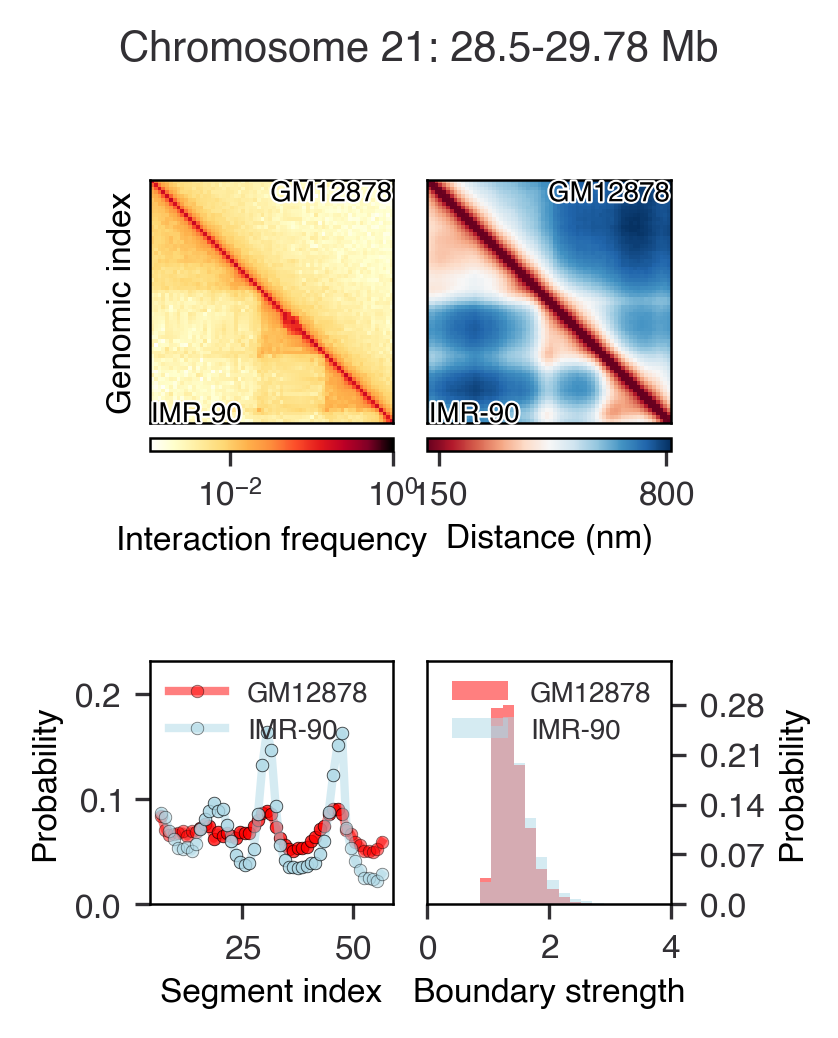

In [20]:
fig,axes=make_plot(combined_gm_tag,combined_imr_tag,legend_text_size='small',
                   chrom=gm_imr_chrom,start=gm_imr_start,stop=gm_imr_stop)

fig.savefig(save_folder + f'GM_IMR_comparison_{gm_imr_chrom}_{gm_imr_start}_combined.pdf')

In [16]:
for key in [
    'GM12878\\21_28500000_29780000_0.8',
    'IMR-90\\21_28500000_29780000_0.8',
    'GM12878\\21_28500000_29780000_0.5',
    'IMR-90\\21_28500000_29780000_0.5'
]:

    print(
        torch.cat([
            torch.tensor(scores) for scores in boundary_data[key]['scorebds_cells']
        ]).median()
    )


tensor(1.3605, dtype=torch.float64)
tensor(1.3714, dtype=torch.float64)
tensor(1.3503, dtype=torch.float64)
tensor(1.3880, dtype=torch.float64)


In [17]:
(1.3714-1.3605)/1.3714, (1.3880-1.3503)/1.3880

(0.007948082251713512, 0.027161383285302484)

#### Show distance maps, as well

Identify the cells with the strongest boundaries

In [38]:
all_gm_scores = []
[all_gm_scores.extend(scores_) for scores_ in boundary_data[gm_tag1]['scorebds_cells']]
all_imr_scores = []
[all_imr_scores.extend(scores_) for scores_ in boundary_data[imr_tag1]['scorebds_cells']]

all_gm_scores = torch.tensor(all_gm_scores)
all_imr_scores = torch.tensor(all_imr_scores)

'''
nbins = 100
maxx = max(scores1.max(),scores2.max())
minn = min(scores1.min(),scores2.min())
delta = (maxx - minn) / nbins
bins = torch.arange(minn,maxx+delta/2,delta)

plt.hist(scores1,bins=bins,alpha=.5,density=True)
plt.hist(scores2,bins=bins,alpha=.5,density=True);
''';

In [39]:
scores1 = torch.tensor([
    torch.tensor( v ).sort(descending=True).values[:2].tolist() for v in boundary_data[gm_tag]['scorebds_cells']
])
scores2 = torch.tensor([
    torch.tensor( v ).sort(descending=True).values[:2].tolist() for v in boundary_data[imr_tag]['scorebds_cells']
])

KeyError: 'GM12878'

In [40]:
gm_scores = torch.tensor([
    torch.tensor(v).mean() for v in boundary_data[gm_tag]['scorebds_cells']
])
imr_scores = torch.tensor([
    torch.tensor( v ).mean() for v in boundary_data[imr_tag]['scorebds_cells']
])

nbounds_gm = torch.tensor([
    len(v) for v in boundary_data[gm_tag]['scorebds_cells']
])
nbounds_imr = torch.tensor([
    len(v) for v in boundary_data[imr_tag]['scorebds_cells']
])



KeyError: 'GM12878'

In [41]:
gm_dists = coord_dict[gm_tag].distances
imr_dists = coord_dict[imr_tag].distances

KeyError: 'GM12878'

In [42]:
gm_idx = torch.where( nbounds_gm == 3 )[0]
gm_idx = gm_idx[ gm_scores[gm_idx].sort(descending=True).indices ][:3:2]

imr_idx = torch.where( nbounds_imr == 3 )[0]
imr_idx = imr_idx[ imr_scores[imr_idx].sort(descending=True).indices ][:2]

fig,axes = plt.subplots(ncols=2,nrows=2,figsize=(8,8),layout='constrained')

gm_dists[gm_idx[0]].plot(fig=fig,ax=axes[0][0],vmax=1500)
gm_dists[gm_idx[1]].plot(fig=fig,ax=axes[0][1],vmax=1500)
imr_dists[imr_idx[0]].plot(fig=fig,ax=axes[1][0],vmax=1500)
imr_dists[imr_idx[1]].plot(fig=fig,ax=axes[1][1],vmax=1500)

NameError: name 'nbounds_gm' is not defined

In [34]:
scores1[:,1].sort(descending=True)

torch.return_types.sort(
values=tensor([2.6060, 2.5144, 2.4334,  ..., 1.0931, 1.0861, 1.0805]),
indices=tensor([1365,  116, 2017,  ..., 4864, 9581, 7391]))

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 30 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'D', 'G', 'I', 'M', 'R', 'a', 'c', 'd', 'e', 'eight', 'five', 'hyphen', 'i', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'parenleft', 'parenright', 's', 'seven', 'space', 't', 'two', 'x', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 19, 20, 21, 24, 26, 27, 28, 39, 42, 44, 48, 53, 68, 70, 71, 72, 76, 80, 81, 82, 86, 87, 91]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 30 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'D', 'G', 'I', 'M', 'R', 'a', 'c', 'd', 'e', 'eight', 'f

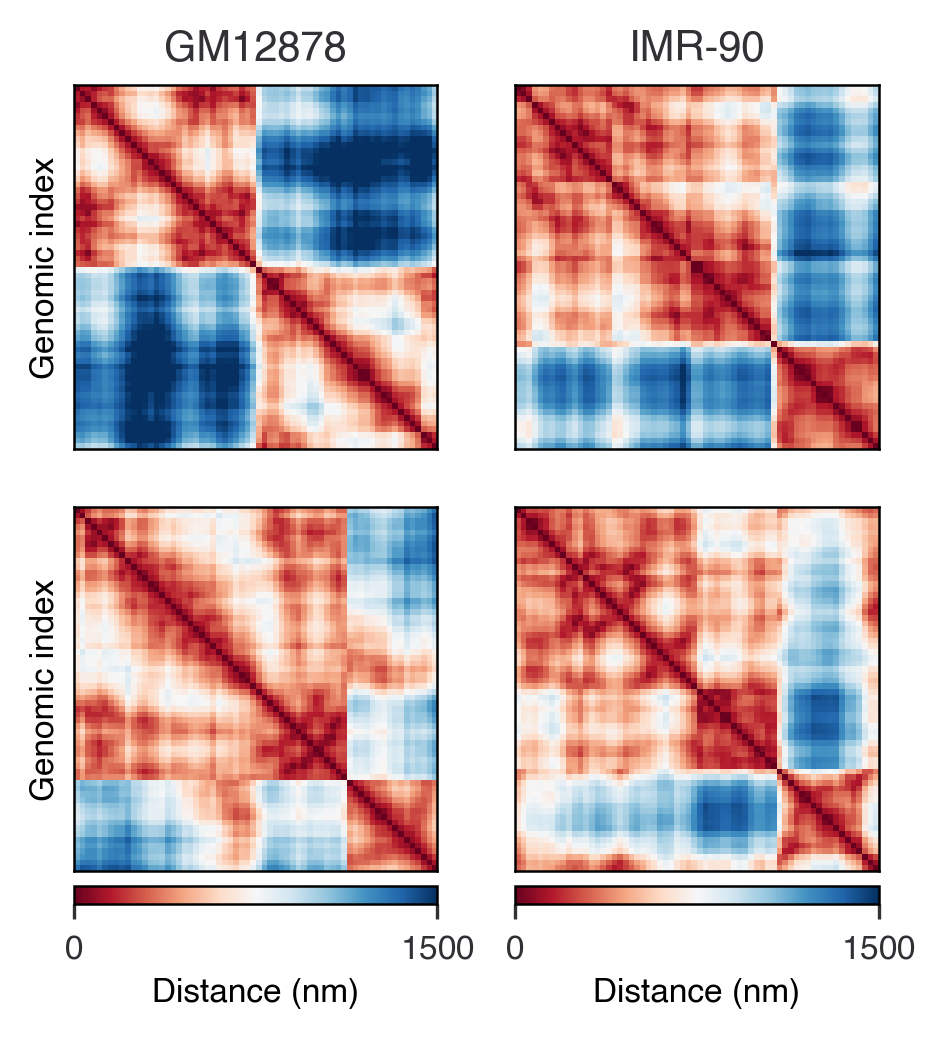

In [91]:
#gm_dists = coord_dict[gm_tag][scores1.sort(descending=True).indices[4:6]].distances
#imr_dists = coord_dict[imr_tag][scores2.sort(descending=True).indices[4:6]].distances

gm_dists = coord_dict[gm_tag][scores1.mean(1).sort(descending=True).indices[2::7]].distances
imr_dists = coord_dict[imr_tag][scores2.mean(1).sort(descending=True).indices[1:4:2]].distances

fig,axes = plt.subplots(ncols=2,nrows=2,figsize=(3,3),layout='constrained')
vmax = 1500
vmin = 0
####
# GM12878
# Upper left
_,ax,_,cbar = gm_dists[0].plot(fig=fig,ax=axes[0][0],vmin=vmin,vmax=vmax,cbar_orientation='horizontal')
cbar.remove()
ax.set_xlabel('')
ax.set_title('GM12878')

# Lower left
_,ax,_,cbar = gm_dists[1].plot(fig=fig,ax=axes[1][0],vmin=vmin,vmax=vmax,cbar_orientation='horizontal')
ax.set_xlabel('')
#ax.set_ylabel('')
cbar.set_label("Distance (nm)")
cbar.set_ticks([vmin,vmax],labels=['$\\mathdefault{'+f'{vmin}'+'}$','$\\mathdefault{'+f'{vmax}'+'}$'])

####
# IMR-90
# Upper right
_,ax,_,cbar = imr_dists[0].plot(fig=fig,ax=axes[0][1],vmin=vmin,vmax=vmax,cbar_orientation='horizontal')
cbar.remove()
ax.set_ylabel('')
ax.set_title('IMR-90')

# Lower right
_,ax,_,cbar = imr_dists[1].plot(fig=fig,ax=axes[1][1],vmin=vmin,vmax=vmax,cbar_orientation='horizontal')
ax.set_ylabel('')
cbar.set_ticks([vmin,vmax],labels=['$\\mathdefault{'+f'{vmin}'+'}$','$\\mathdefault{'+f'{vmax}'+'}$'])
cbar.set_label('Distance (nm)')

fig.savefig(save_folder + 'distance_maps.pdf',transparent=True)

(<Figure size 2400x2400 with 8 Axes>,
 <Axes: xlabel='Genomic index', ylabel='Genomic index'>,
 <matplotlib.colorbar.Colorbar at 0x7f73f9af63e0>)

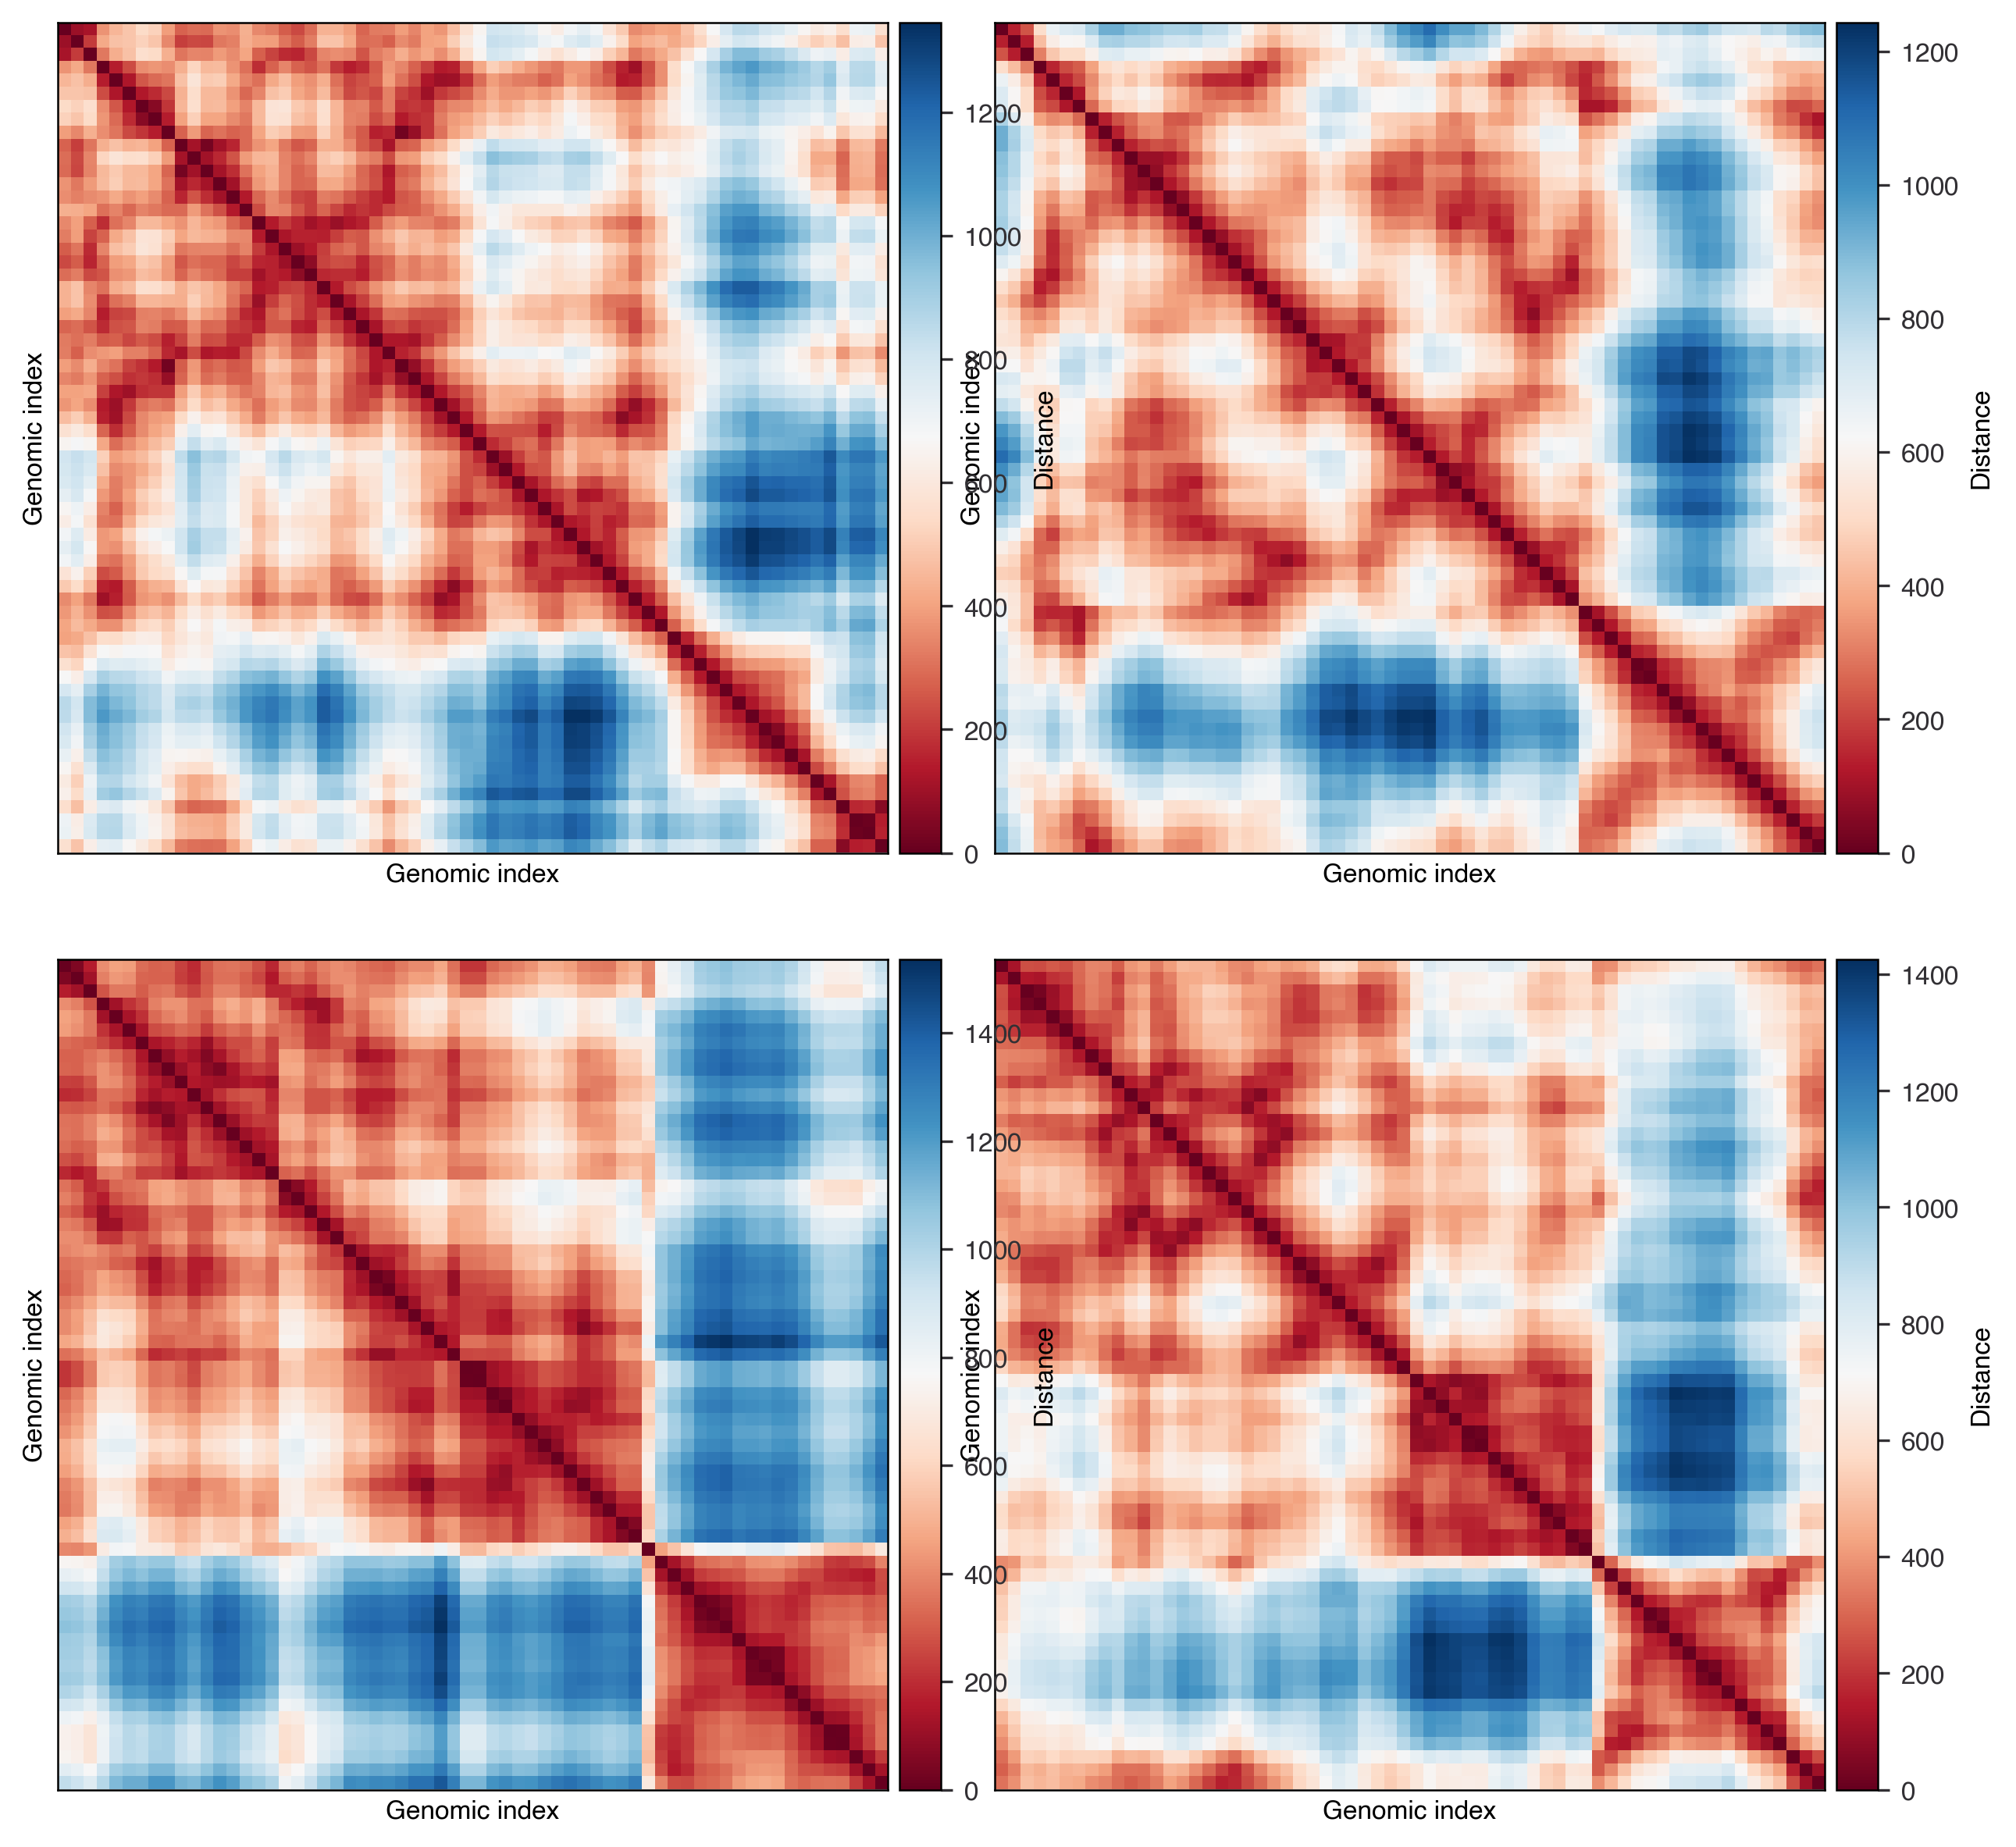

In [68]:
gm_dists = coord_dict[gm_tag].distances

best_gm = (gm_dists.values - imr_dists[1].values).square().sum((-1,-2)).sort(descending=False).indices

fig,axes = plt.subplots(ncols=2,nrows=2,figsize=(8,8),layout='constrained')
gm_dists[best_gm[0]].plot(fig=fig,ax=axes[0][0])#,vmax=1000)
gm_dists[best_gm[1]].plot(fig=fig,ax=axes[0][1])#,vmax=1000)
imr_dists[0].plot(fig=fig,ax=axes[1][0])#,vmax=1000)
imr_dists[1].plot(fig=fig,ax=axes[1][1])#,vmax=1001)

In [66]:
imr_dists = coord_dict[imr_tag].distances
imr_mean = imr_dists.mean
best_imr = (imr_dists.values - imr_mean.values).square().sum((-1,-2)).sort(descending=False).indices

gm_dists = coord_dict[gm_tag].distances
best_gm = (gm_dists.values - imr_mean.values).square().sum((-1,-2)).sort(descending=False).indices

(<Figure size 2400x2400 with 8 Axes>,
 <Axes: xlabel='Genomic index', ylabel='Genomic index'>,
 <matplotlib.colorbar.Colorbar at 0x7f73f9ffd600>)

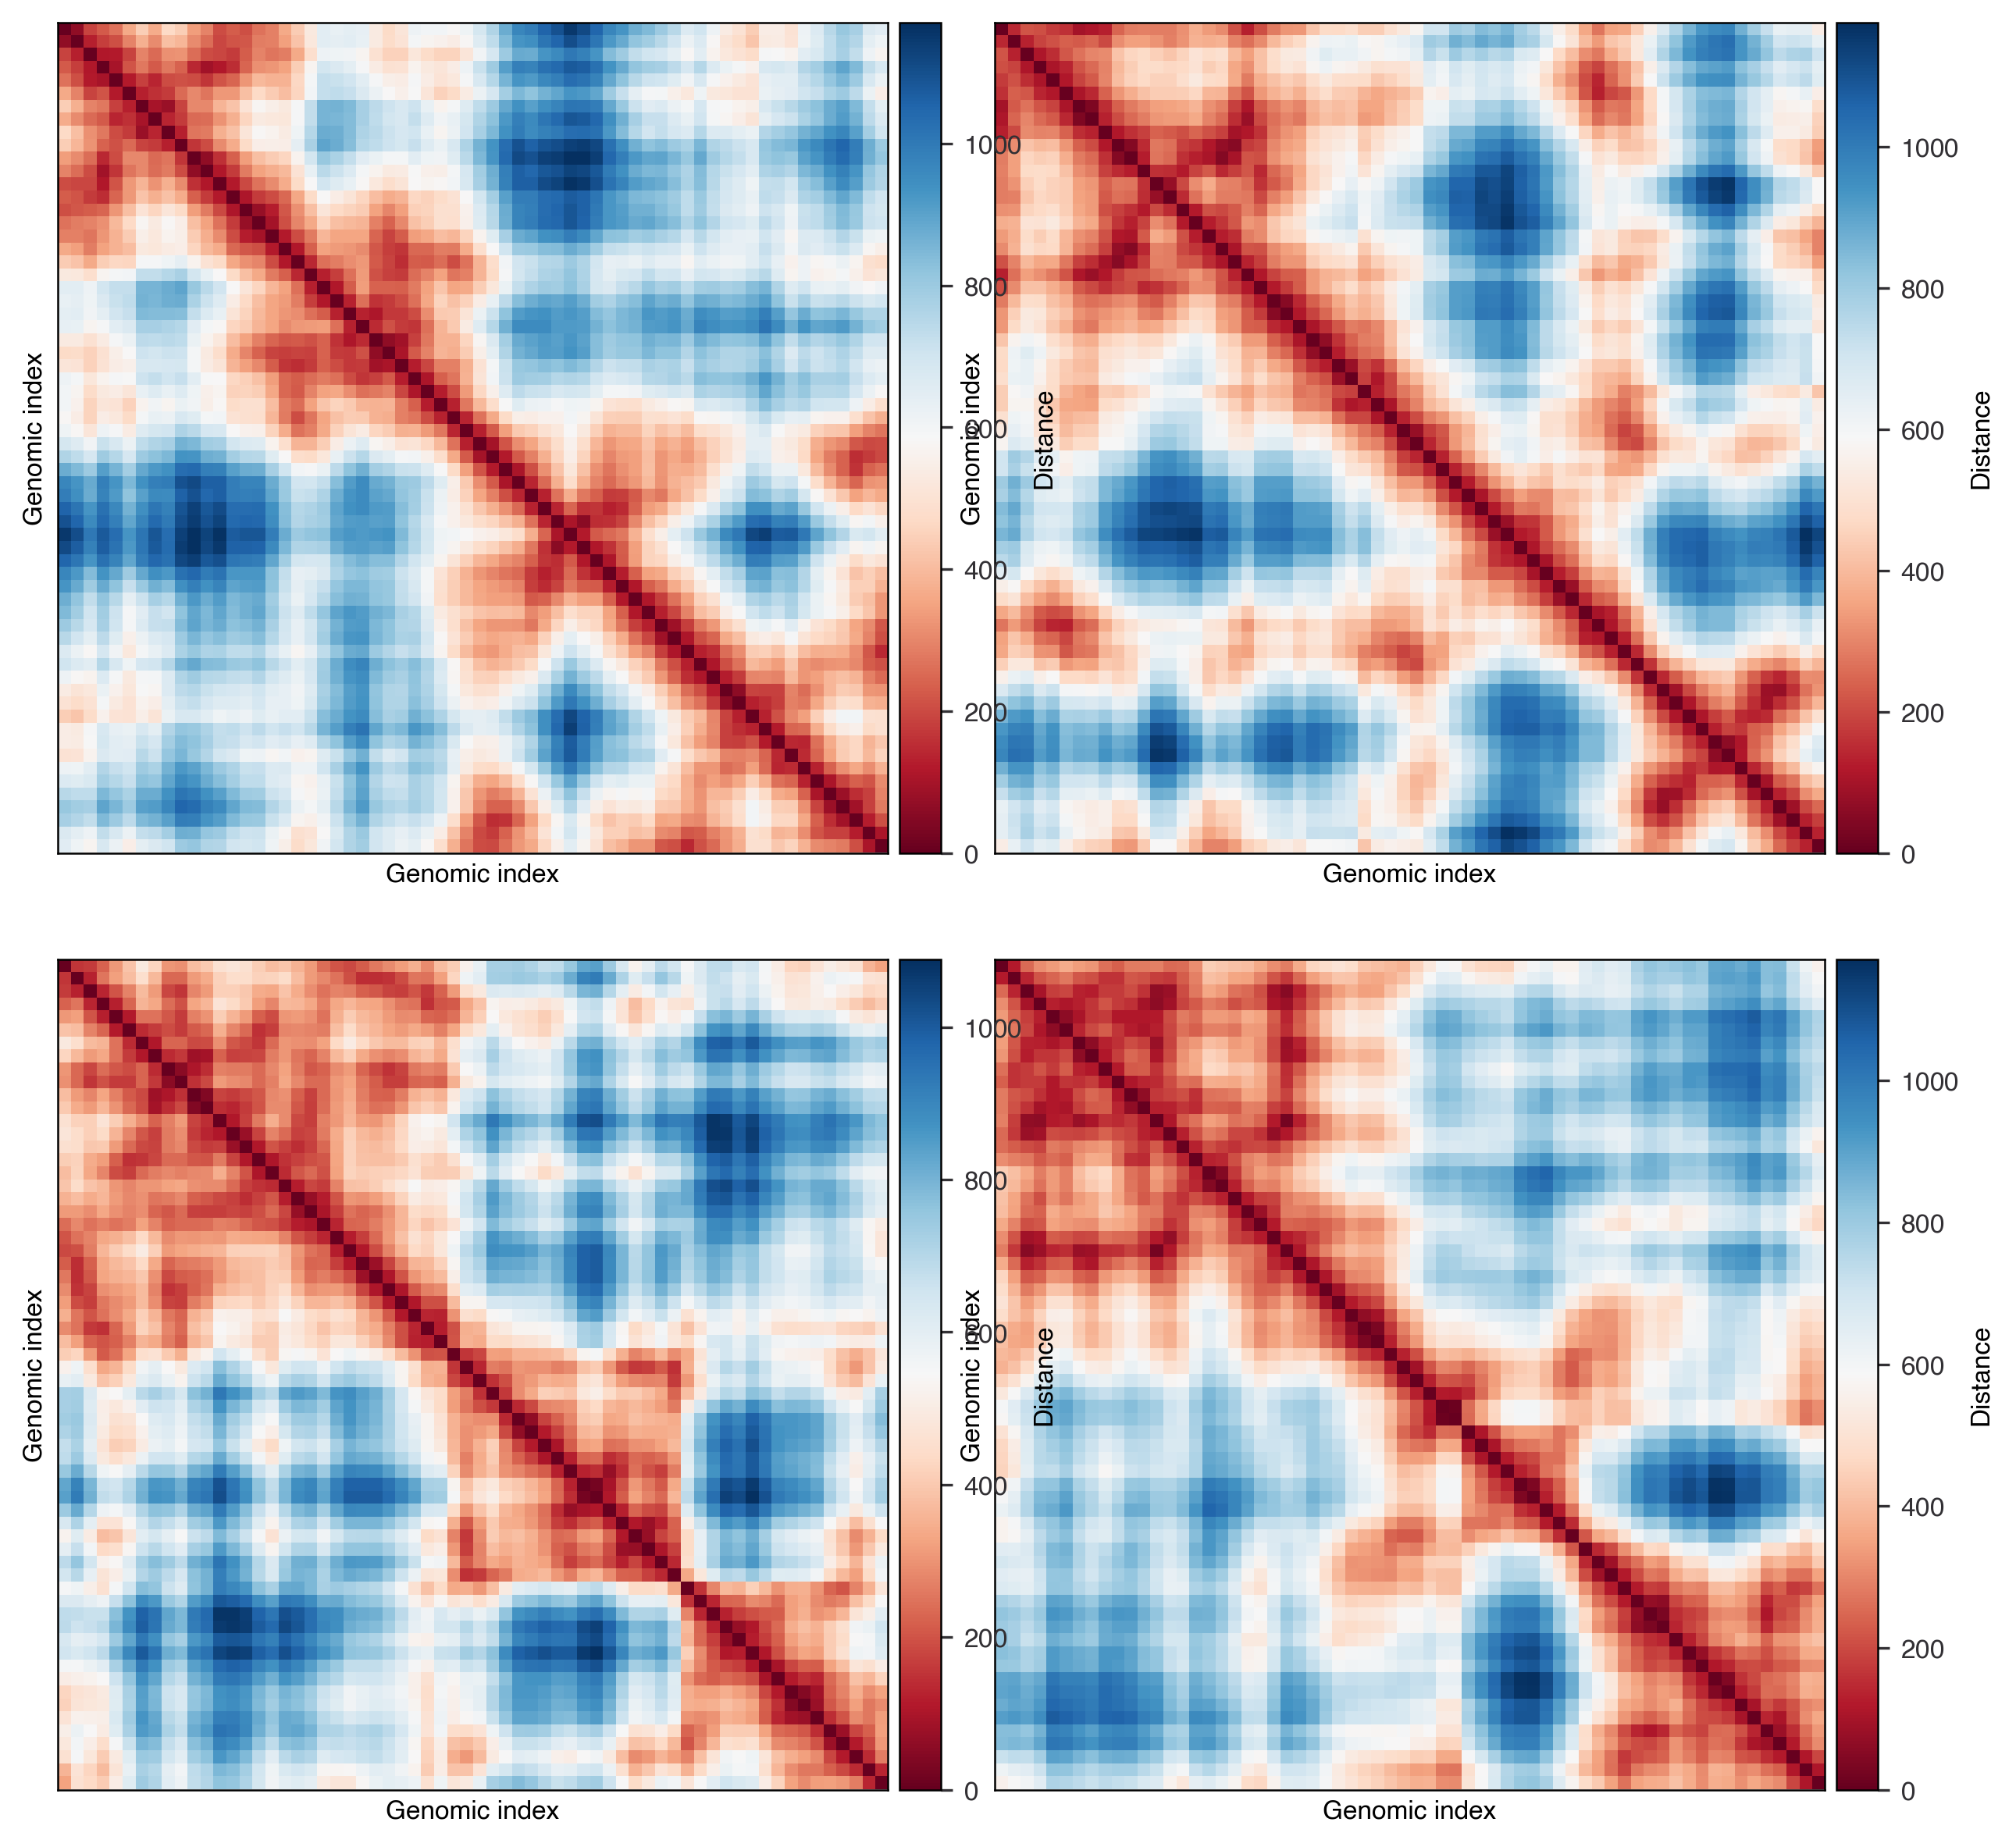

In [65]:
fig,axes = plt.subplots(ncols=2,nrows=2,figsize=(8,8),layout='constrained')
gm_dists[best_gm[0]].plot(fig=fig,ax=axes[0][0])#,vmax=1000)
gm_dists[best_gm[1]].plot(fig=fig,ax=axes[0][1])#,vmax=1000)
imr_dists[best_imr[0]].plot(fig=fig,ax=axes[1][0])#,vmax=1000)
imr_dists[best_imr[1]].plot(fig=fig,ax=axes[1][1])#,vmax=1001)

In [132]:
m1 = all_gm_scores.median()
m2 = all_imr_scores.median()
(m1-m2)/m2

tensor(-0.0636, dtype=torch.float64)

In [133]:
m1,m2

(tensor(1.3320, dtype=torch.float64), tensor(1.4225, dtype=torch.float64))

In [32]:
gm_dists = Coordinates(gm_conformation_fp).float().distances
imr_dists = Coordinates(imr_conformation_fp).float().distances
gm_dists._values*= 100
imr_dists._values*= 100

(<Figure size 1920x1440 with 2 Axes>,
 <Axes: xlabel='Genomic index', ylabel='Genomic index'>,
 <matplotlib.colorbar.Colorbar at 0x7fc16bd6ab30>)

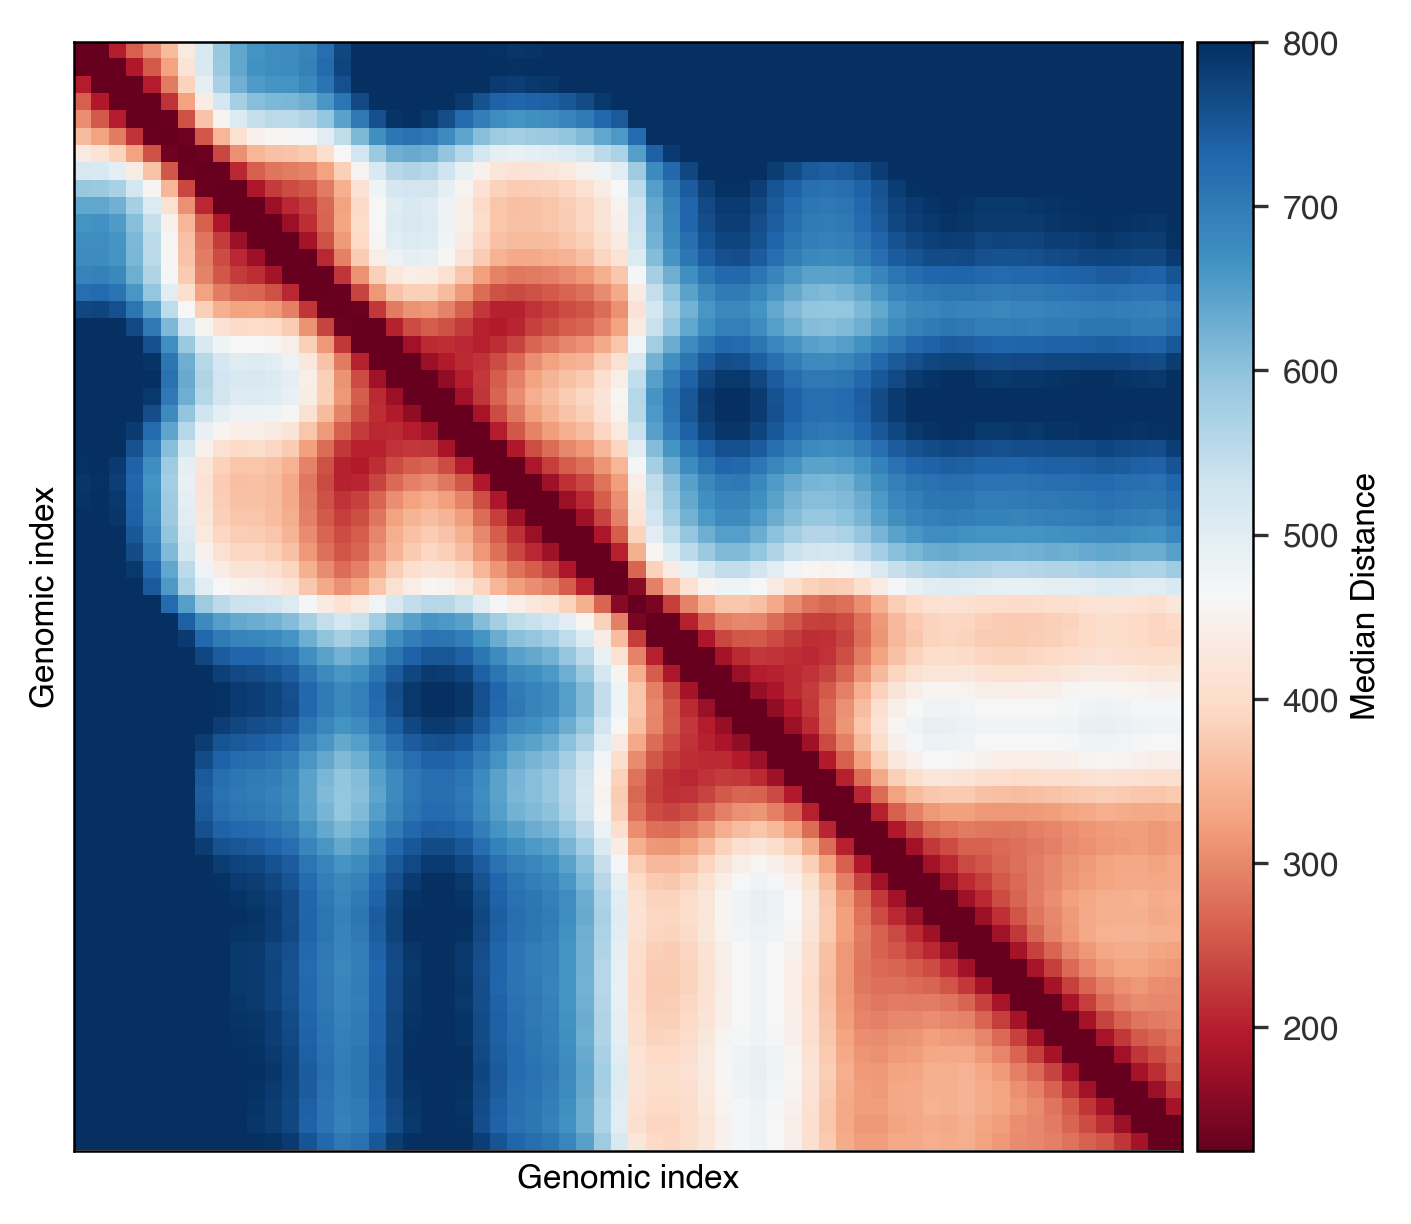

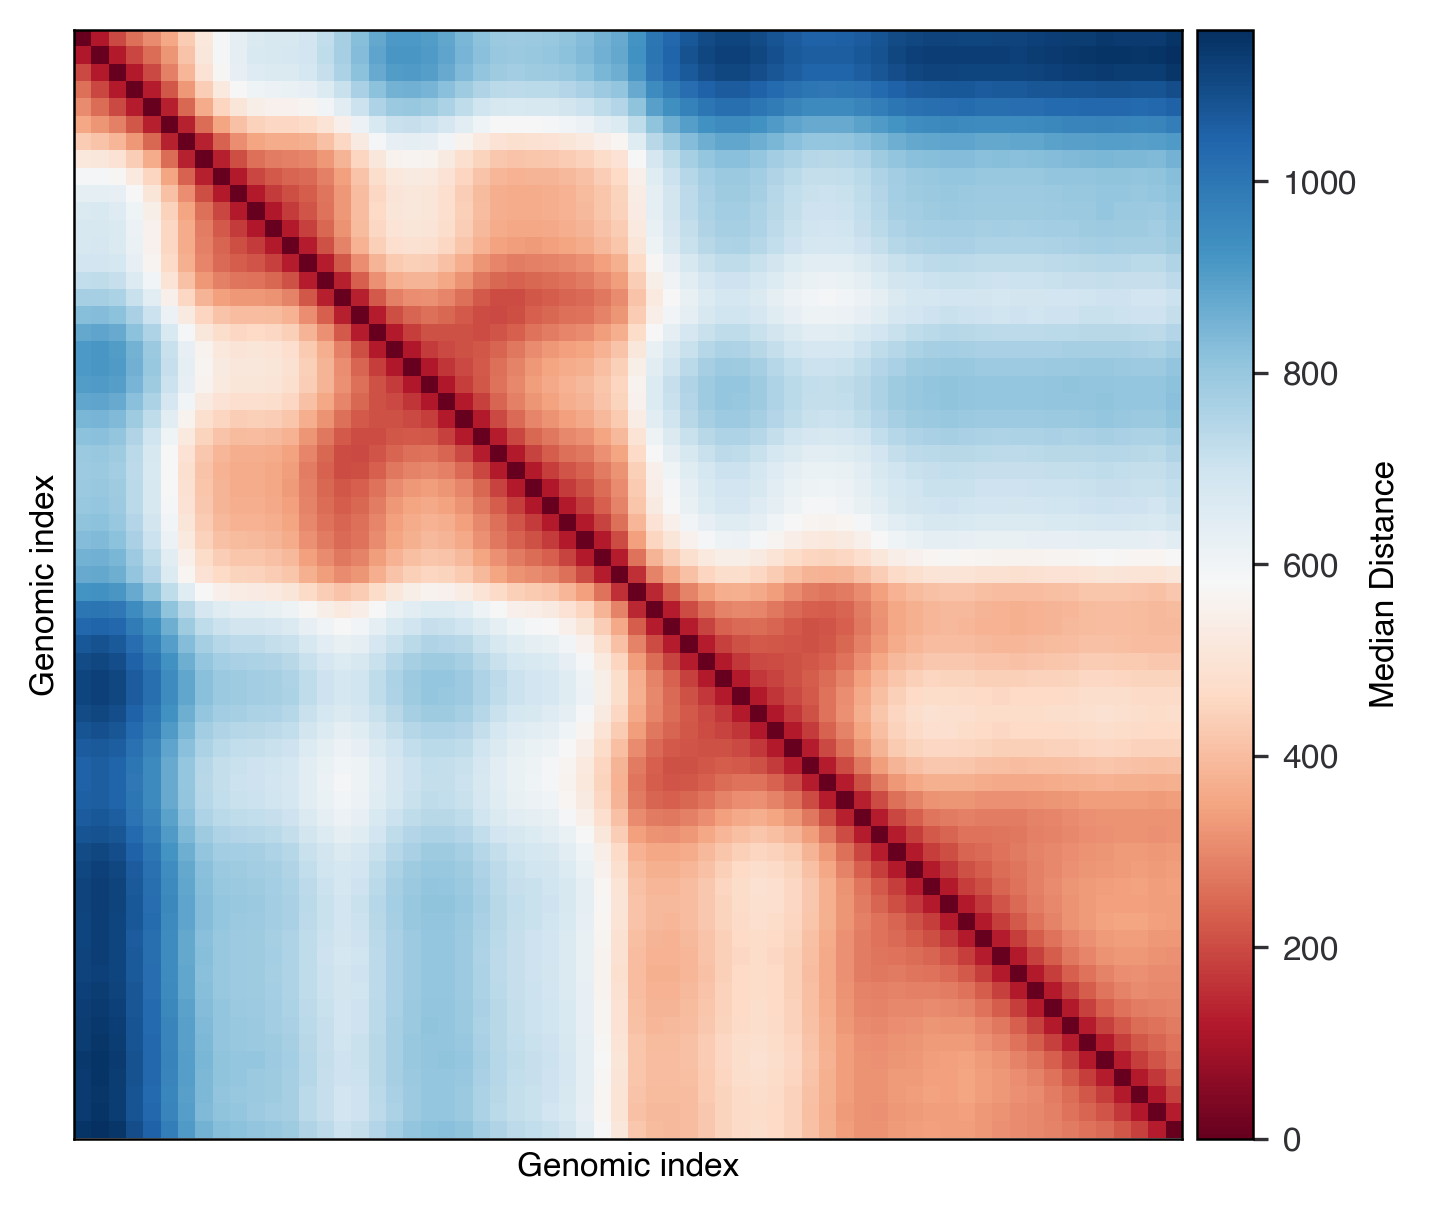

In [68]:
a = Coordinates(features_fp).float().distances
a._values*= 100
a.median.plot(vmax=800,vmin=125)
a.median.plot()

(<Figure size 1920x1440 with 2 Axes>,
 <Axes: xlabel='Genomic index', ylabel='Genomic index'>,
 <matplotlib.colorbar.Colorbar at 0x7fc16bcbeb00>)

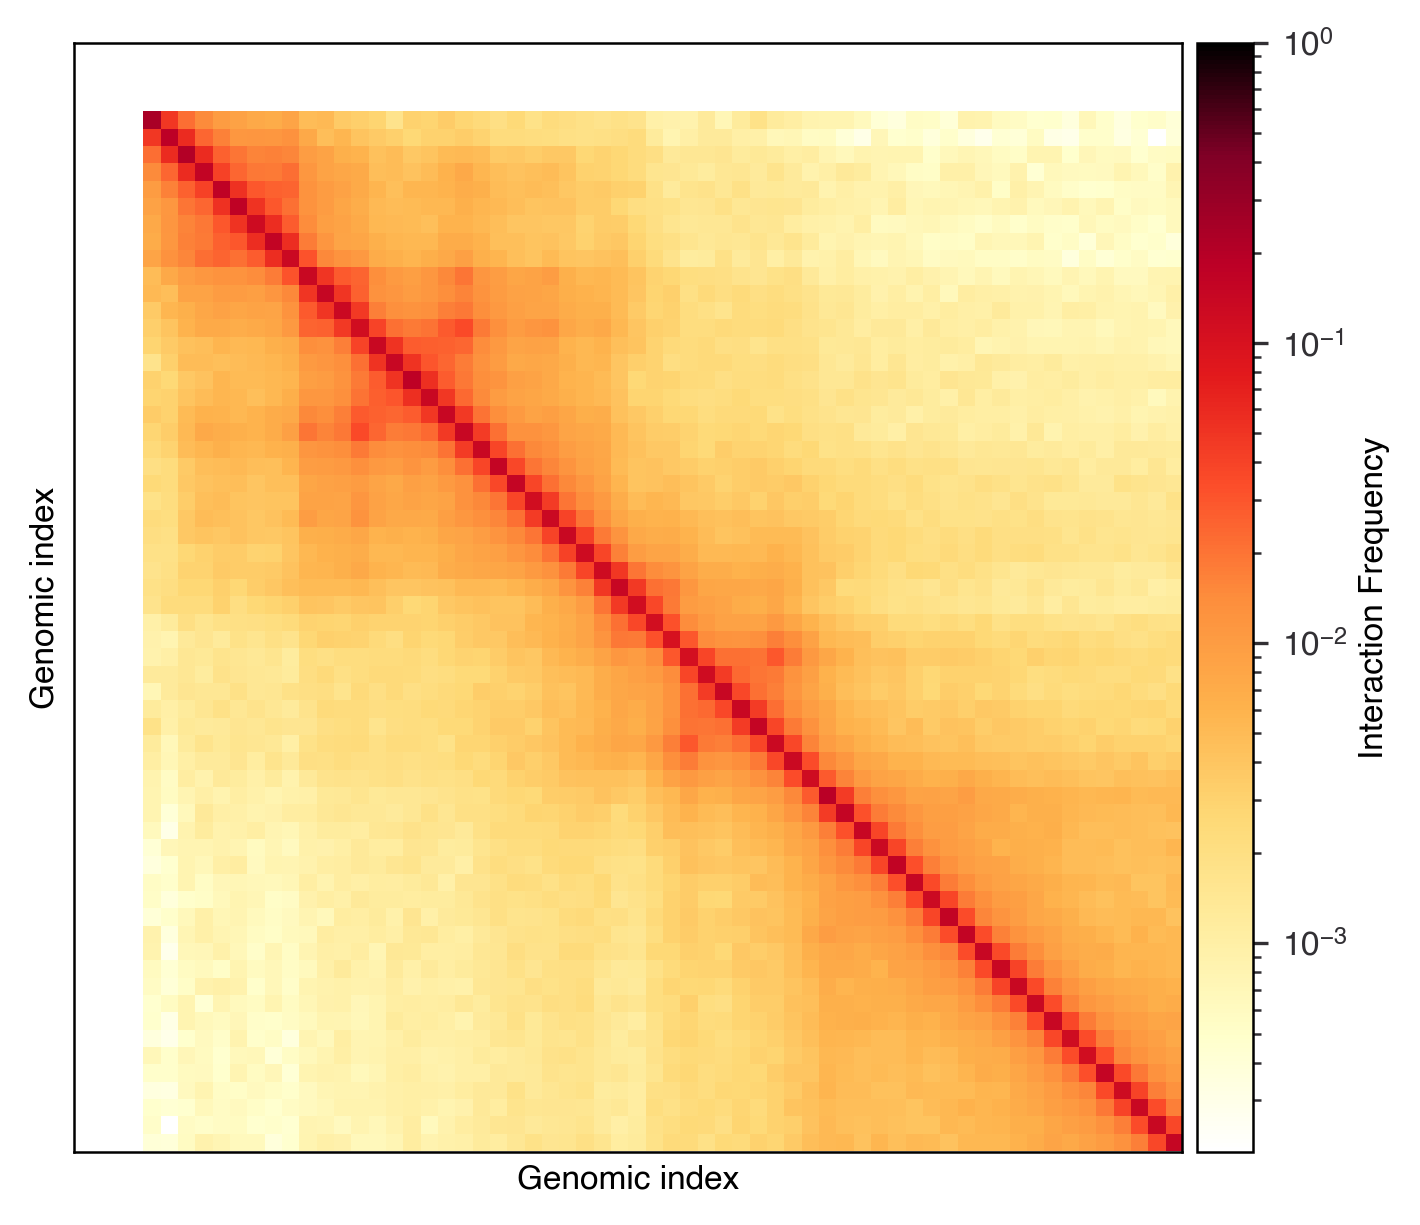

In [67]:
hic_maps['Chromosome 1: 17.12-18.4 Mb'].plot()

In [20]:
asdf

NameError: name 'asdf' is not defined

In [ ]:
#a = Coordinates('/home/gridsan/gschuette/binz_group_shared/gkks/with_Zhuohan/conformations/unguided.pt')
a = Coordinates('/home/gridsan/gschuette/binz_group_shared/gkks/with_Zhuohan/conformations/Tan/unguided_equivalent.pt')

In [ ]:
d = a.distances

In [ ]:
dm = d.mean_by_bond_separation

In [ ]:
i,j = torch.triu_indices(64,64,1)

In [ ]:
x = torch.arange(20,64)
y = dm.values[0,0,x]

In [ ]:
plt.plot(x,y)
plt.xscale('log')
plt.yscale('log')

In [ ]:
np.polyfit(x.log().numpy(),y.log().numpy(),1)

In [ ]:
1/0.35970244

In [ ]:
sys.path.insert(2,'../code/data_utils/')
from ConfigDataset import ConfigDataset

In [ ]:
config_ds = ConfigDataset(
    '../data/processed_data.hdf5',
    segment_length=64,
    remove_diagonal=False,
    batch_size=0,
    normalize_distances=False,
    geos=None,
    organisms=None,
    cell_types=None,
    cell_numbers=None,
    chroms=['1','2','3','4','5'],
    replicates=None,
    shuffle=True,
    allow_overlap=False,
    two_channels=False,
    try_GPU=True,
    mean_dist_fp='../data/mean_dists.pt',
    mean_sq_dist_fp='../data/squares.pt'
)

In [ ]:
genomic_regions = config_ds.get_genomic_regions()

In [ ]:
hic = []
dist = []
i,j = torch.triu_indices(64,64,10)
for _,row in genomic_regions.iterrows():

    hic_map = gm_hic.fetch( row.Chromosome, row.Start, row.Stop )

    hic_data = hic_map.prob_map[i,j]
    idx = torch.where(hic_data.isfinite())[0]

    hic.append(hic_data[idx])
    dist.append(
        Coordinates(
            config_ds.fetch_specific_coords(row.Chromosome,row.Start)[1]
        ).distances.median.values[0,i,j][idx]
    )

hic = torch.cat(hic)
dist = torch.cat(dist)

In [ ]:
np.polyfit(hic.log().numpy(),dist.log().numpy(),1)

In [162]:
(torch.randn(1_000_000) * .2).std()

tensor(0.1999)

In [164]:
sys.path.insert(2,'../code/diffusion_compartmental/model_files')
sys.path.insert(3,'../code/Sampler/')
from Sampler import Sampler

In [165]:
sampler = Sampler(
    model_dir='../data/models/diffusion_origami_64_no_embed_reduction/',
    save_file=None,
    samples_device=torch.device('cpu'),
    # U-Net options
    dim=64,
    cond_drop_prob = 0.,
    init_dim = None,
    out_dim = None,
    dim_mults=(1, 2, 4, 8),
    channels = 2,
    resnet_block_groups = 8,
    learned_variance = False,
    learned_sinusoidal_cond = False,
    random_fourier_features = False,
    learned_sinusoidal_dim = 16,
    attn_dim_head = 32,
    attn_heads = 4,
    embedding_dimensions=(1,256,256),
    # Diffusion model options
    image_size=32,
    timesteps = 1000,
    sampling_timesteps = None,
    objective = 'pred_noise',
    beta_schedule = 'cosine',
    ddim_sampling_eta = 1.,
    offset_noise_strength = 0.,
    min_snr_loss_weight = False,
    min_snr_gamma = 5,
    cond_scale=None,
    rescaled_phi=None
)


FileNotFoundError: [Errno 2] No such file or directory: '../../data/mean_dists.pt'

In [2]:
dists = Coordinates('../data/samples/origami_64_no_embed_reduction/eval_mode/unused/sample_395_1.0_0.0_120_1.pt').distances

(<Figure size 1920x1440 with 2 Axes>,
 <Axes: xlabel='Genomic index', ylabel='Genomic index'>,
 <matplotlib.colorbar.Colorbar at 0x7f64201c13f0>)

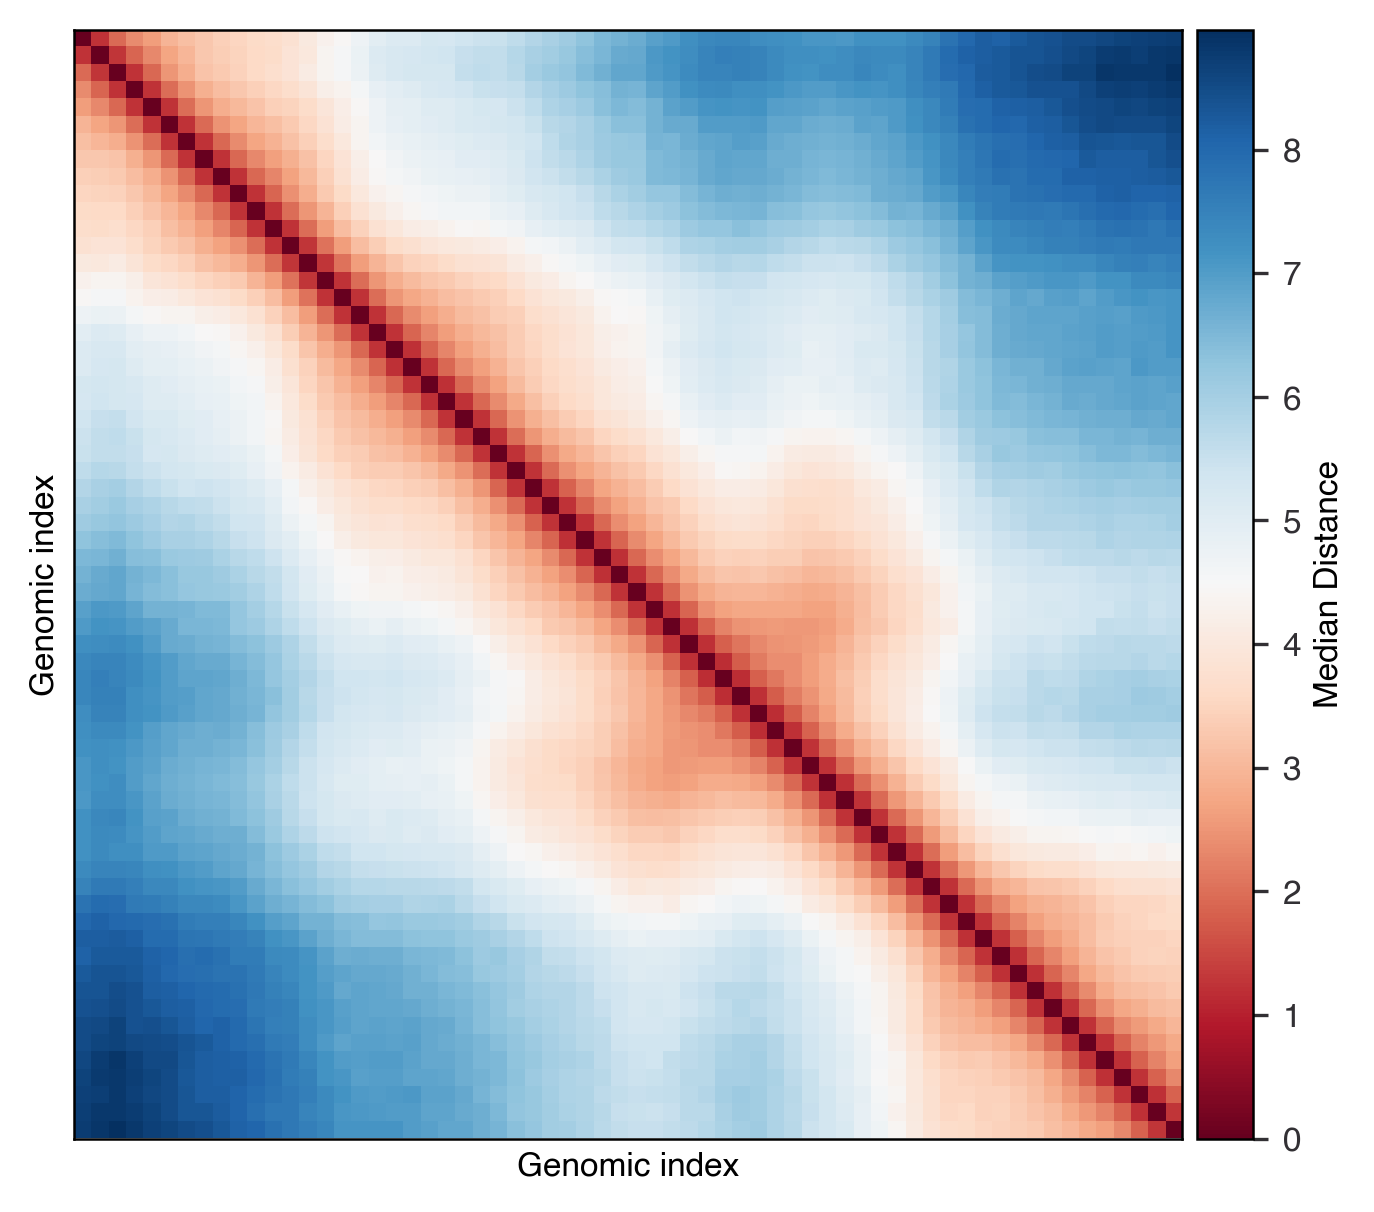

In [3]:
dists.median.plot()

In [24]:
from Distances import Distances
from HiCMap import HiCMap
def conformations_to_probs(conformations,sigma=3.72,r_c=1.5,return_map=True):

    if type(conformations) == torch.Tensor:
        try:
            conformations = Coordinates(conformations)
        except:
            conformations = Distances(conformations).unfold().unnormalize()
    
    p = conformations.distances.values.clone()
    
    mask = p < r_c
    p[mask] = ( (sigma*(r_c-p[mask])).tanh() + 1 )/2
    mask^= True
    p[mask] = (r_c/p[mask])**3.45 / 2
    if return_map:
        p = p.mean(0)
        return HiCMap(p)
    else:
        return p

(<Figure size 1920x1440 with 2 Axes>,
 <Axes: xlabel='Genomic index', ylabel='Genomic index'>,
 <matplotlib.colorbar.Colorbar at 0x7f635c2b9930>)

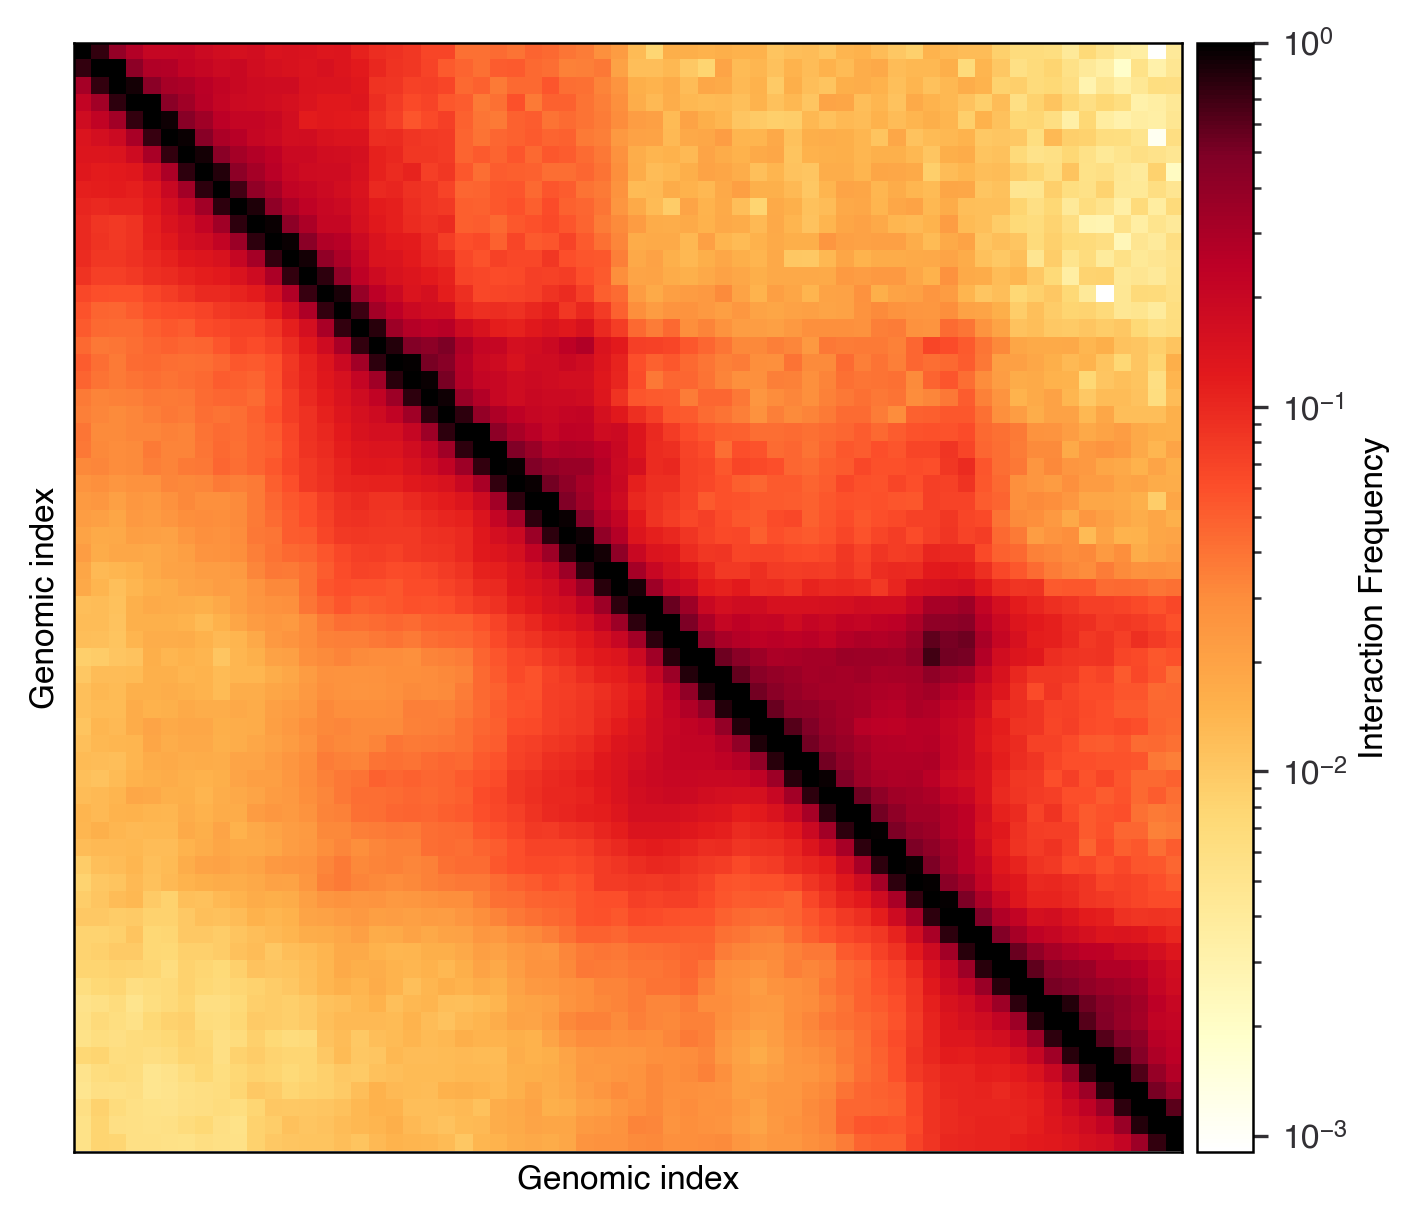

In [22]:
gen_map = conformations_to_probs(dists)
exp_map = gm_hic.fetch('1',7_380_000,8_660_000)

exp_map.prob_map/= torch.nanmean(exp_map.prob_map[range(63),range(1,64)])
exp_map.plot_with(gen_map)

In [127]:
from tqdm.auto import tqdm
from torcheval.metrics.functional import r2_score

def optimize_subset(conformations,target_map,num_iterations=25_000,lr=.001):

    n = conformations.num_beads
    assert n == target_map.prob_map.shape[-1]

    i,j = torch.triu_indices(n,n,1)
    
    probs = conformations_to_probs(conformations,sigma=3.72,r_c=1.5,return_map=False)[:,i,j].float()

    target = target_map.prob_map.float()
    target = target[i,j] / torch.nanmean(target[range(n-1),range(1,n)])

    N = len(conformations)
    weights = torch.ones(N,1)#.fill_(1/N)

    with tqdm(total=num_iterations,initial=0) as pbar:
        
        for i in range(num_iterations):

            temp_weights = weights.clone()
            temp_weights.requires_grad_(True)

            mean_probs = (temp_weights/temp_weights.sum() * probs).sum(0)

            #loss = 1 - r2_score(mean_probs,target)
            loss = (mean_probs - target).square().sum()
            loss.backward()

            weights-= lr * temp_weights.grad.data

            weights.clip_(min=0)
            #weights/= weights.sum()

            if i==0:
                pbar.set_description(f'loss: {loss:.4f}')
                
            if (i+1)%100 == 0:
                pbar.set_description(f'loss: {loss:.4f}')
                pbar.update(100)

    return weights
    

In [161]:
from tqdm.auto import tqdm
from torcheval.metrics.functional import r2_score

def optimize_subset(conformations,target_map,num_iterations=1000,lr=.05):

    n = conformations.num_beads
    assert n == target_map.prob_map.shape[-1]

    i,j = torch.triu_indices(n,n,1)
    
    probs = conformations_to_probs(conformations,sigma=3.72,r_c=1.5,return_map=False)[:,i,j].float()

    target = target_map.prob_map.float()
    target = target[i,j] / torch.nanmean(target[range(n-1),range(1,n)])
    
    N = len(conformations)
    weights = torch.ones(N,1).requires_grad_(True)
    
    optimizer = torch.optim.LBFGS(
        [weights], 
        lr=lr, 
        max_iter=20, 
        max_eval=None, 
        tolerance_grad=1e-08, 
        tolerance_change=1e-10, 
        history_size=100, 
        line_search_fn=None
    )

    with tqdm(total=num_iterations,initial=0) as pbar:
        
        def closure():
            
            optimizer.zero_grad()
    
            mean_probs = (weights/weights.sum() * probs).sum(0)
    
            loss = (mean_probs - target).square().sum()
            loss = loss - (1_000_000 * weights[weights < 0]).sum()
            loss.backward()

            pbar.set_description(f'loss: {loss:.4f}')
            
            return loss
    
        for i in range(num_iterations):
            optimizer.step(closure)
            pbar.update(1)

    return weights.detach()
    

In [172]:
exp_map = gm_hic.fetch('1',7_380_000,8_660_000)
#dists = Coordinates('../data/samples/origami_64_no_embed_reduction/eval_mode/unused/sample_395_1.0_0.0_120_1.pt').distances
dists = Coordinates('../data/samples/origami_64_no_embed_reduction/eval_mode/unused/sample_395_2.5_0.1_120_1.pt').distances
weights = optimize_subset(dists,exp_map,lr=.001)

  0%|          | 0/1000 [00:00<?, ?it/s]

(<Figure size 1920x1440 with 2 Axes>,
 <Axes: xlabel='Genomic index', ylabel='Genomic index'>,
 <matplotlib.colorbar.Colorbar at 0x7f6344371840>)

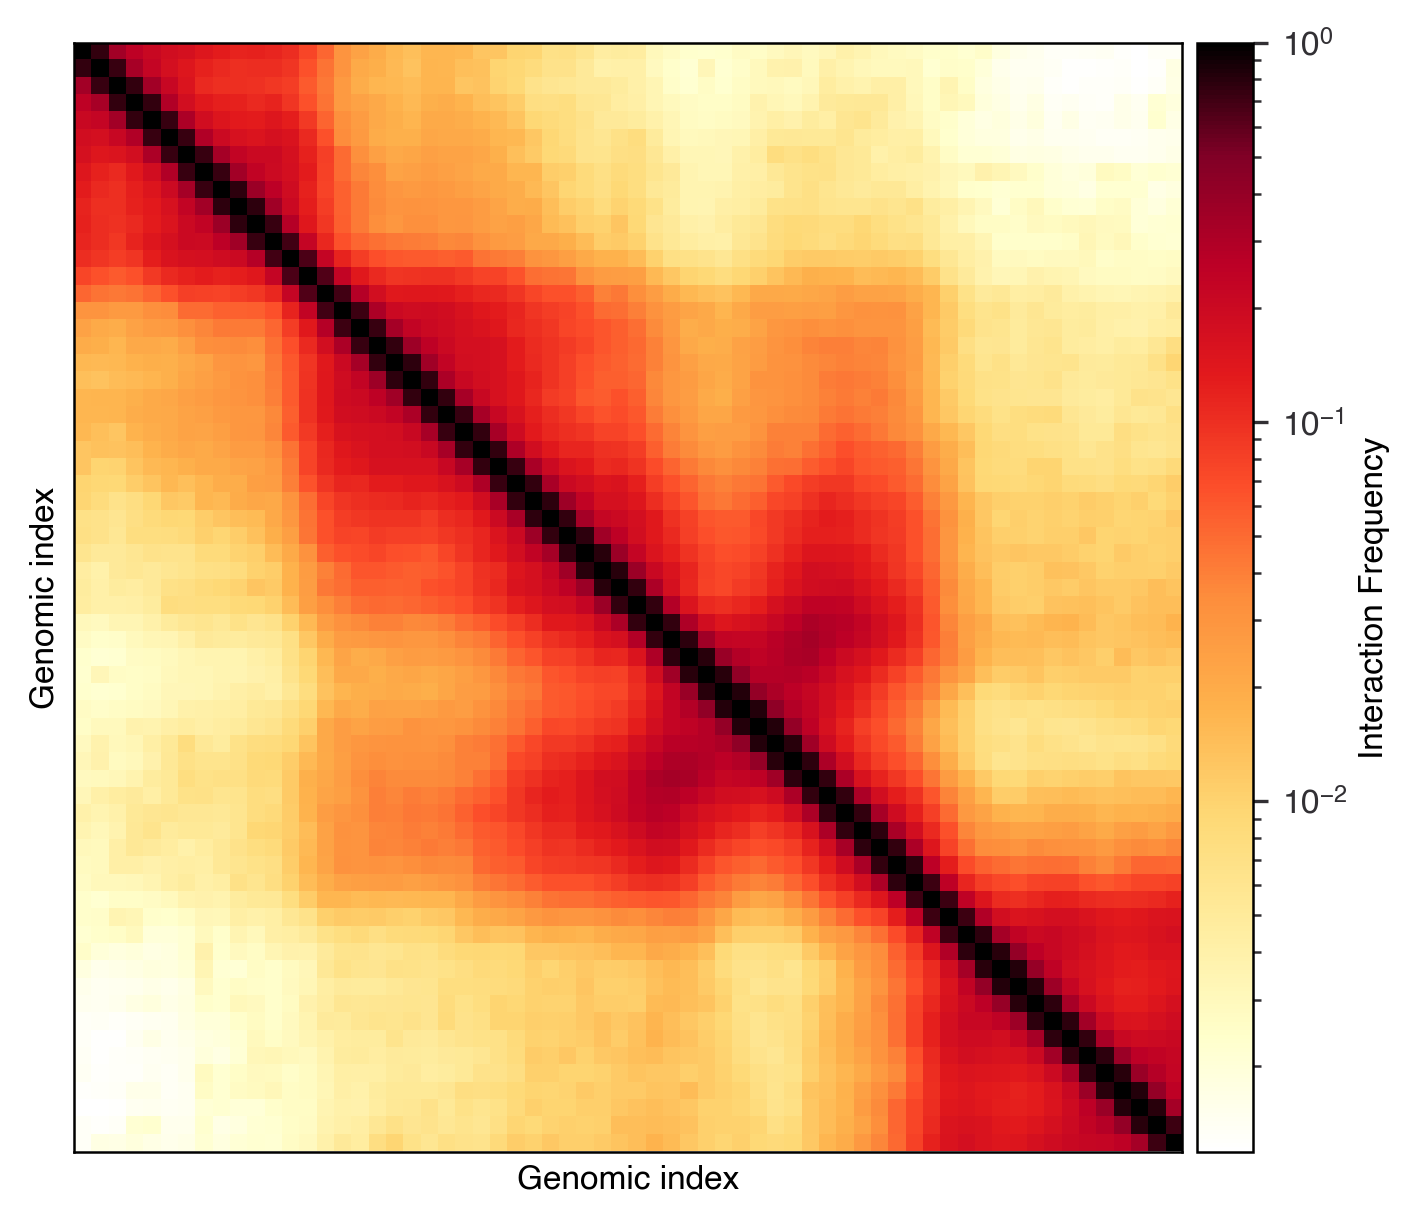

In [173]:
probs = conformations_to_probs(dists,sigma=3.72,r_c=1.5,return_map=False)
#HiCMap( ((weights.unsqueeze(-1)) * probs).mean(0) ).plot()
HiCMap( ((weights.unsqueeze(-1)/weights.sum()) * probs).sum(0) ).plot()

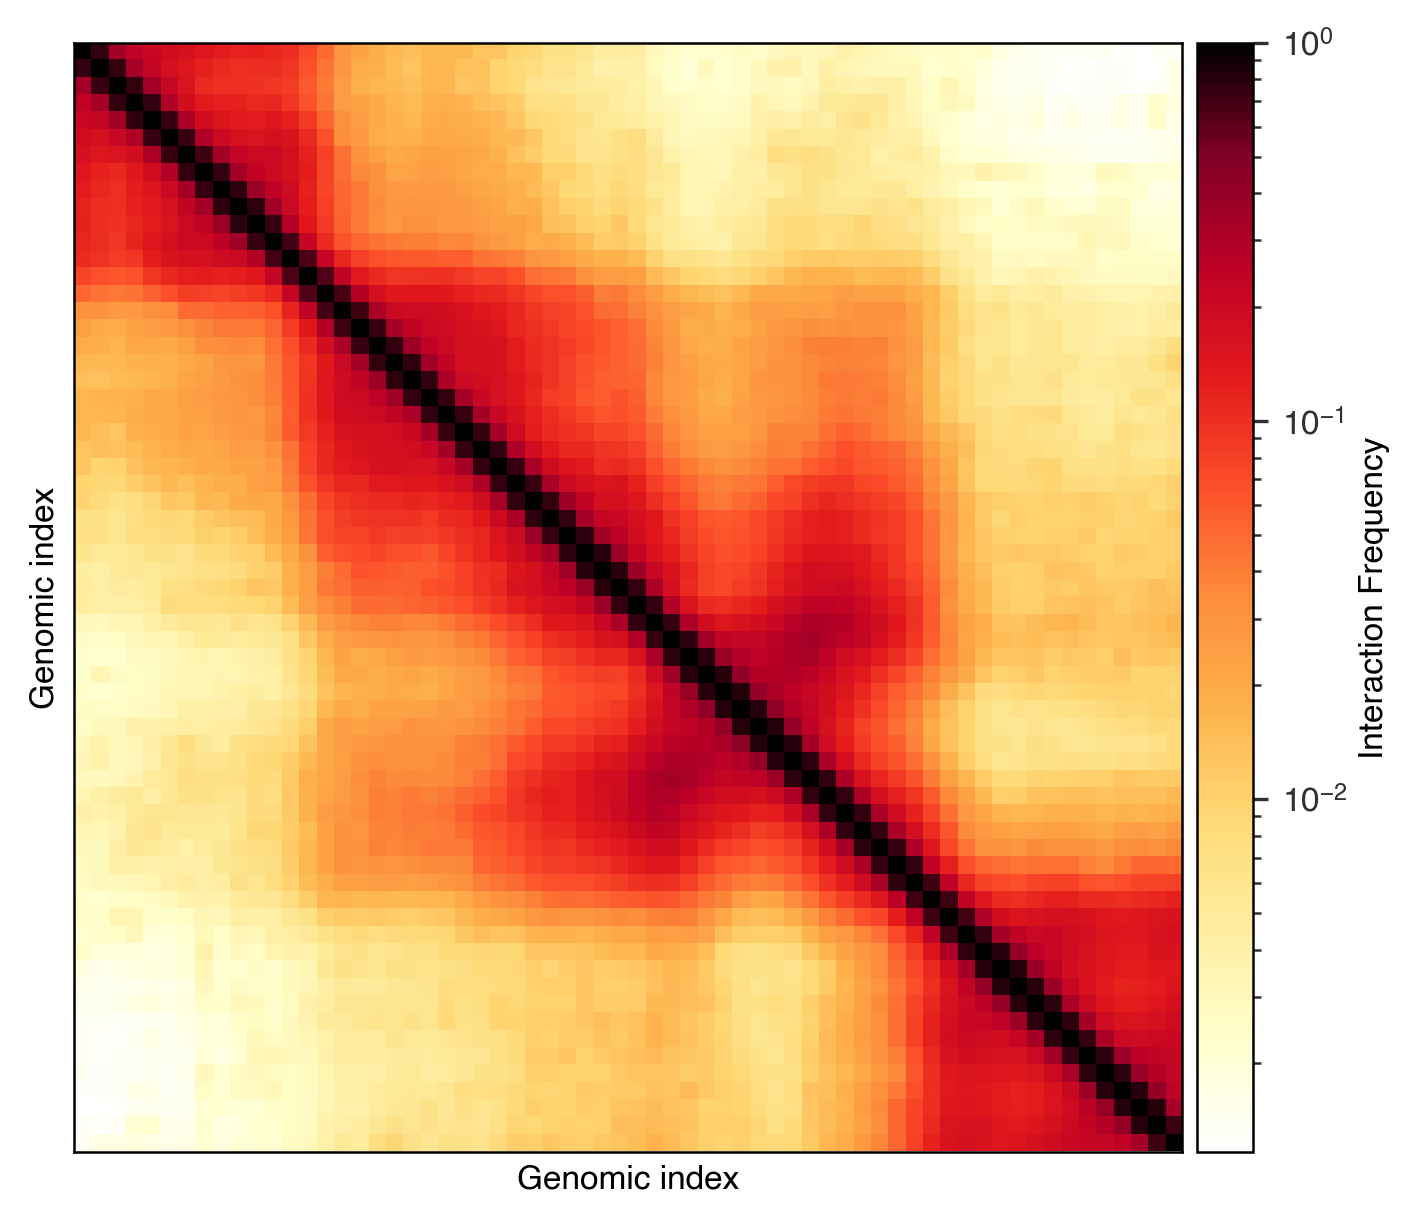

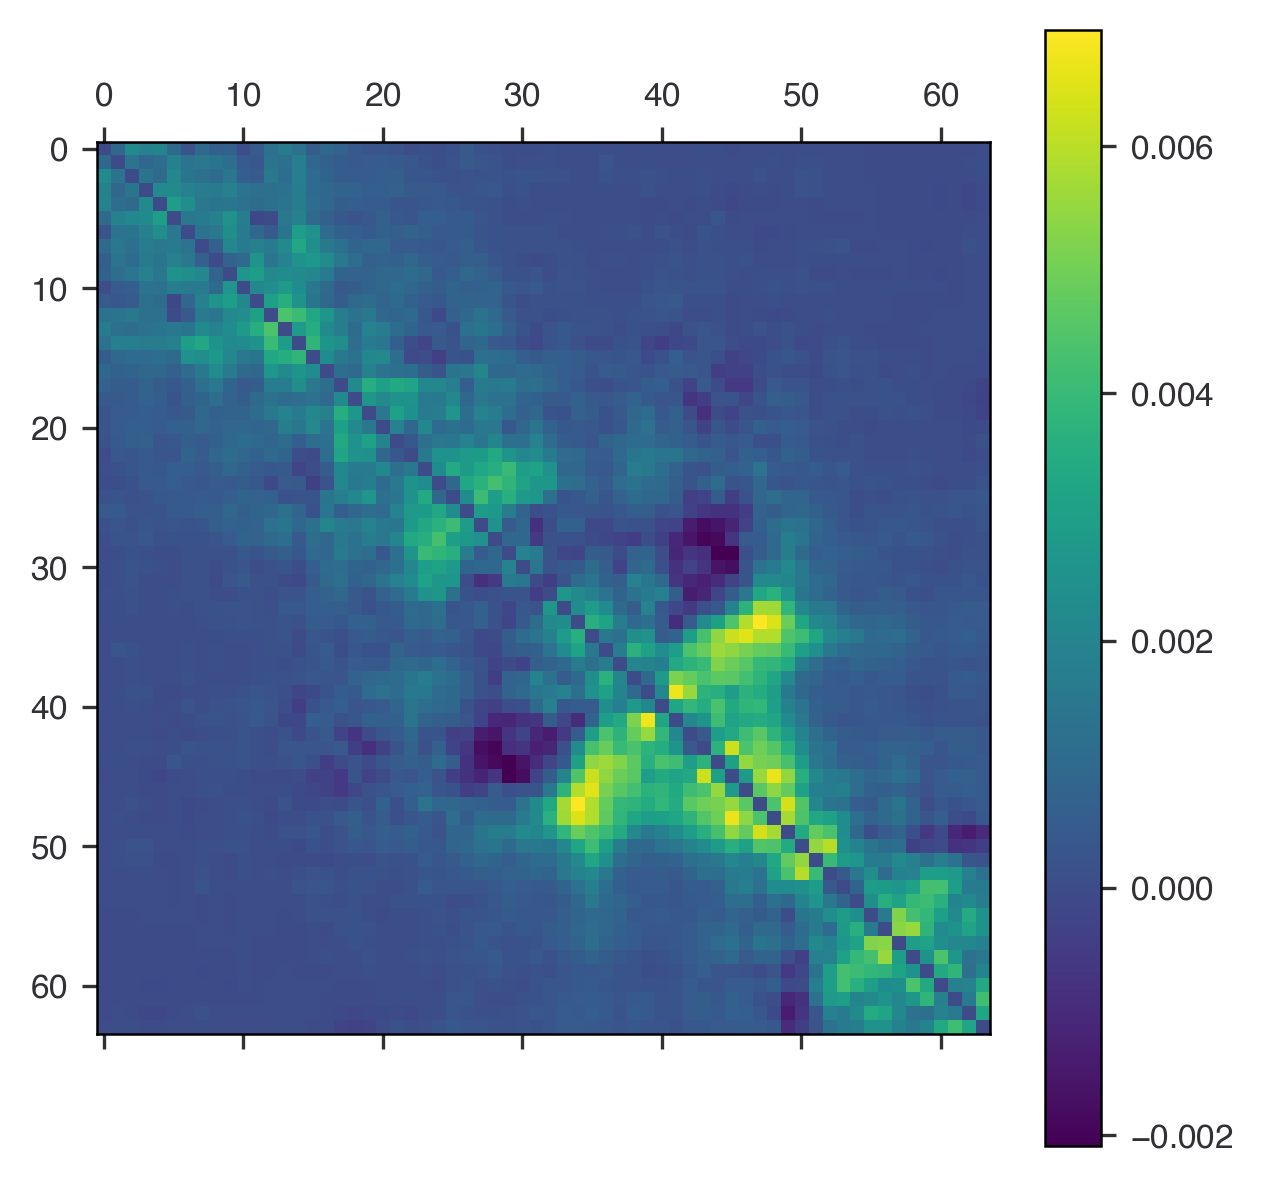

In [174]:
raw = conformations_to_probs(dists,sigma=3.72,r_c=1.5,return_map=True)
weighted = HiCMap( ((weights.unsqueeze(-1)/weights.sum()) * probs).sum(0) )

raw.plot_with(weighted)

plt.matshow( (weighted.prob_map-raw.prob_map) )
plt.colorbar()

(array([  8.,  72., 240., 358., 198.,  94.,  24.,   2.,   3.,   1.]),
 array([0.00070356, 0.00078607, 0.00086857, 0.00095108, 0.00103358,
        0.00111609, 0.00119859, 0.0012811 , 0.0013636 , 0.00144611,
        0.00152862]),
 <BarContainer object of 10 artists>)

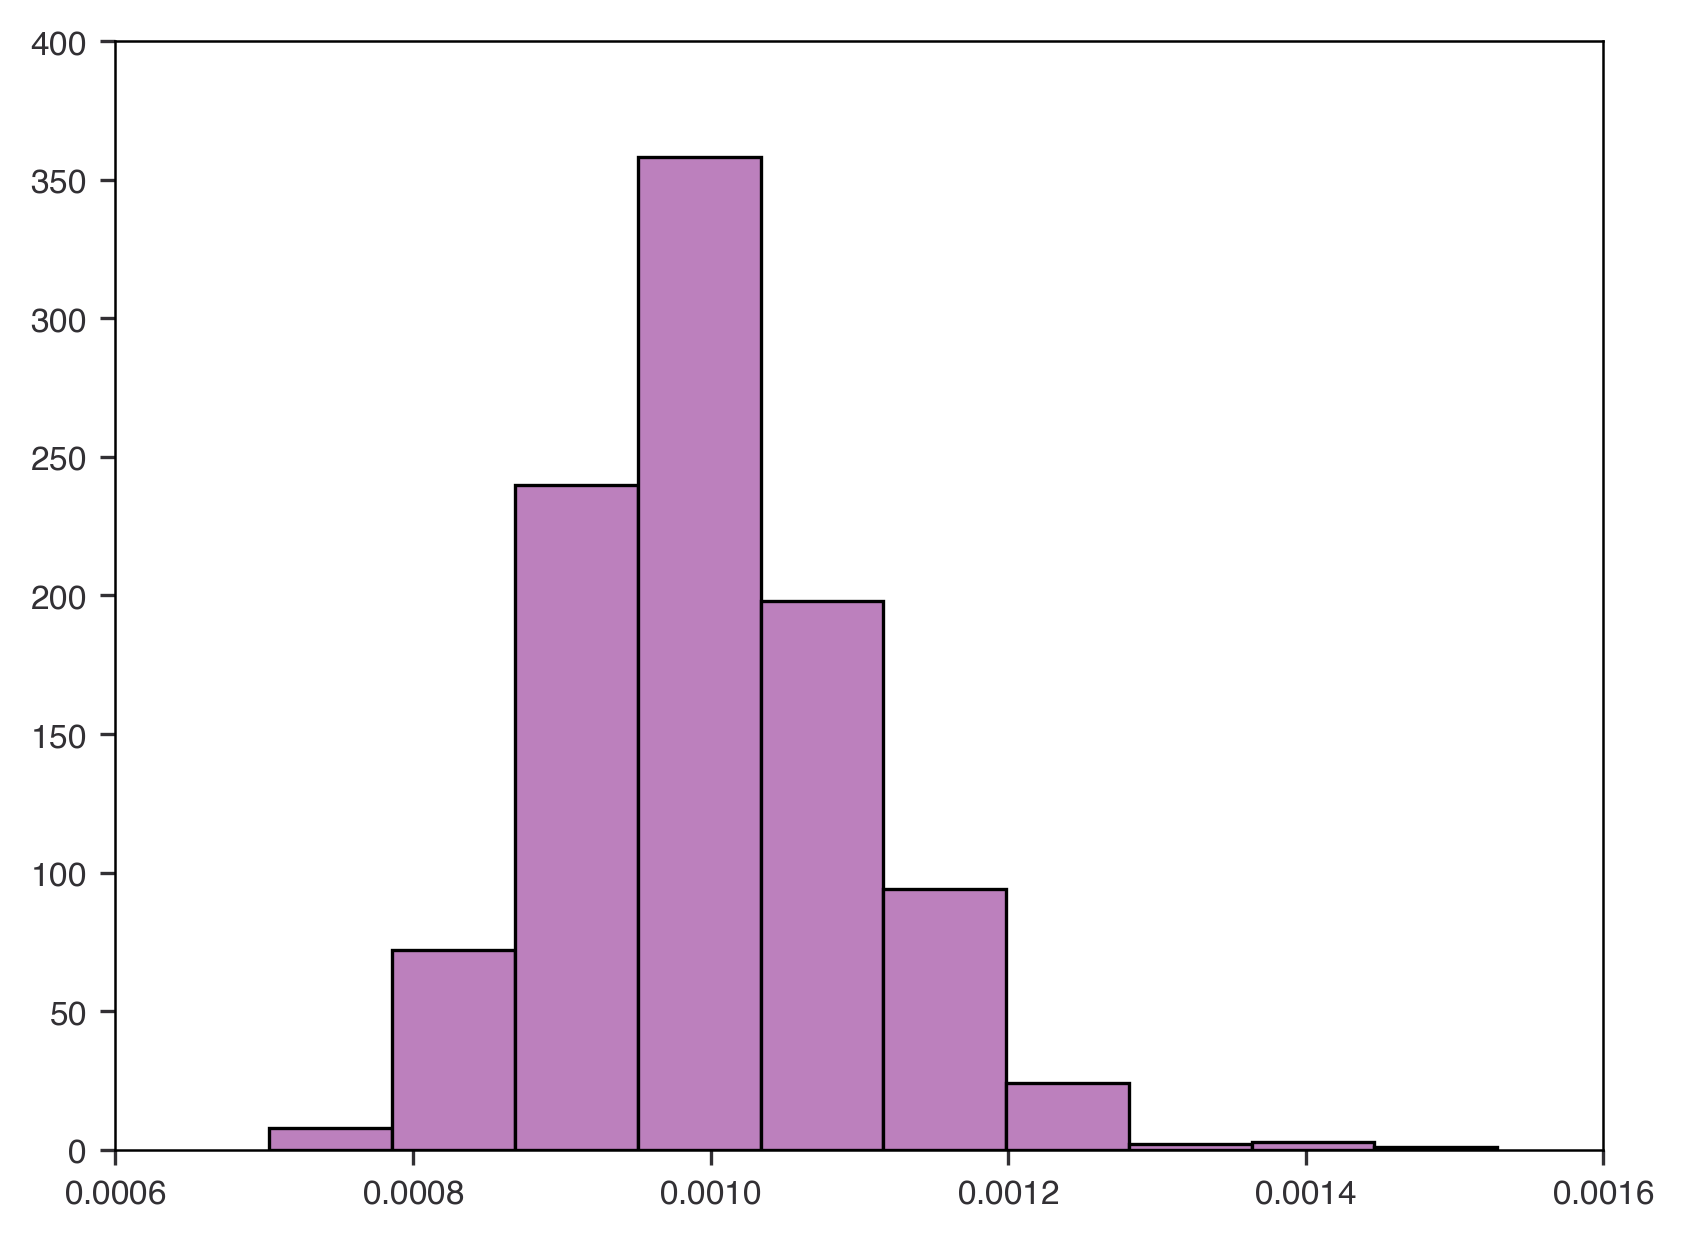

In [175]:
plt.hist((weights/weights.sum()).flatten().numpy())

In [165]:
24.729/20.41*21.644

26.224129152376282

In [170]:
import pandas as pd
rosetta = pd.read_pickle('../data/embeddings_64_after_transformer/rosetta_stone.pkl')
i=0
while rosetta['21'][i][-1] != 28_500_000:
    i+=1
i,rosetta['21'][i][-1]

(668, 28500000)

In [174]:
5.586/4.715 * 

8.959

In [ ]:
hESC = HiCDataset('/home/gridsan/gschuette/IdealChain/')